# Plot Twists
A notebook about common plotting mistakes, how to avoid them, and how to go the extra mile to make extra pretty publication-ready figures using Python alone.

I use the following import and startup lines as the beginning to almost all my code. It contains the core Python modules and then some shortcuts to use parts of matplotlib. The final block sets some defaults for plotting (and viewing in a notebook on a Mac Retina display).

In [1]:
## Core
# These are things you will almost certainly always need
import re, os, sys, string
import pandas as pd
import numpy as np

## Plotting
# Shortcuts to important chunks of matplotlib
# You can change what you call them, but there
# are community standards that will make your
# life easier as you Google for help
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import cm
from matplotlib import colors as mcolors

## Some plot defaults
# These are particular details that you may
# want to change but are good starting points
# display plots in notebook, not in separate window
%matplotlib inline
%config InlineBackend.figure_format ='retina' # improves graphics on Mac retina displays
plt.rcParams['font.family'] = "sans-serif" # use sans serif fonts by default
plt.rcParams['font.sans-serif'] = 'Arial' # make Arial my default sans seric font
plt.rcParams['pdf.fonttype'] = 42 # use TrueType fonts so they can be editted later

## Topics
Most people will never know your paper exists. A small subset will subset will read the abstract, and some fraction of them will skim the paper. Unfortuneately, most papers are not read in detail even by the people citing them! **Creating easily readable and nice looking figures is paramount when communicating research -- it is likely the main way others will interact with your work!**

Here are some topics I'll cover, mostly in this order, but don't hold me to it exactly.
1. Group differences
    - Showing distributions
    - Axes and grids
    - Labeling
2. Styling and how to avoid misleading readers
    - Data scales
    - Ordering data
    - LaTex and print formating
    - Markers
    - Colors, color palettes, and colormaps
    - Complex subplots with `subplot_mosaic`
3. Plotting RNAseq-like data
   - Time series
   - Heat maps
   - Clustering

## 1. Group differences
### Showing distributions
Visualizing the distribution of your data is often the first and last thing you do. You might get your data back and quickly plot them to get a sense of what they look like, and finally you might run some tests comparing groups of data and show those results to your audience. While we do this sort of thing all the time, it's not always so straightforward!

Let's generate some data on unicorn horn length from seven different populations of wild unicorns from the Upper Penninsula.

In [2]:
size = 20
np.random.seed(9999)
hl = [
    sorted(np.random.gamma(shape=5, scale=20, size=size)),
    sorted(np.random.gamma(shape=20, scale=5, size=size)),
    sorted(np.random.normal(loc=100, scale=5, size=size)),
    sorted(np.random.normal(loc=100, scale=10, size=size)),
    sorted(np.random.normal(loc=100, scale=20, size=size)),
    sorted(np.random.uniform(low=0, high=200, size=size)),
    np.concatenate([np.random.normal(loc=50, scale=5, size=int(size/2)), np.random.normal(loc=150, scale=5, size=int(size/2))])]

In [3]:
hornLen = pd.DataFrame(hl).T
uPops = ['Isle Royale', 'Pictured Rocks', 'Mackinac Island', 'Porcupine Mountains', 'Craig Lake', 'Twin Lakes', 'Keweenaw']
hornLen.columns = uPops
hornLen.head()

Isle Royale  Pictured Rocks  Mackinac Island  Porcupine Mountains  \
0    36.552388       62.768853        88.515381            76.110309   
1    38.745385       65.128051        90.744353            83.954419   
2    48.619956       80.280818        92.601437            85.776513   
3    50.529259       82.362704        92.861026            90.529400   
4    67.702317       82.396076        93.395561            94.335185   

   Craig Lake  Twin Lakes   Keweenaw  
0   56.074839    4.037562  45.379878  
1   64.692058   26.979433  45.853796  
2   65.078810   38.688261  57.192897  
3   68.208622   43.469909  46.741455  
4   76.508576   45.342323  56.030256

Now let's make a few simple plots. I like the use `plt.subplots` (or `plt.subplot_mosaic` when I have many subplots, see below) because it's easy to specify the size and structure of your subplots, or even a single plot. When saving plots, these setting are used to make sure they look exactly as they do on the screen. If you use the `figsize` parameter, you can simply specify a journal's figure dimension requirements and forget about having the resize them later.

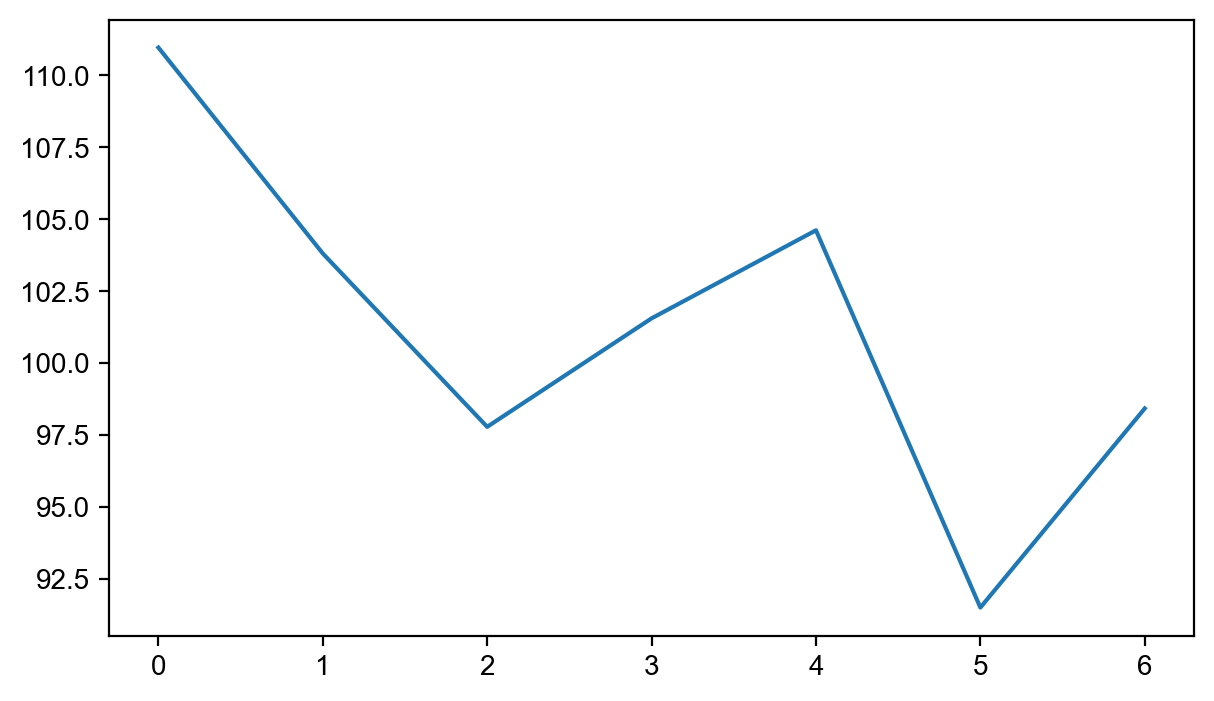

In [4]:
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(range(len(uPops)), hornLen.mean().values)

Whoa! Some of these populations looks really different!

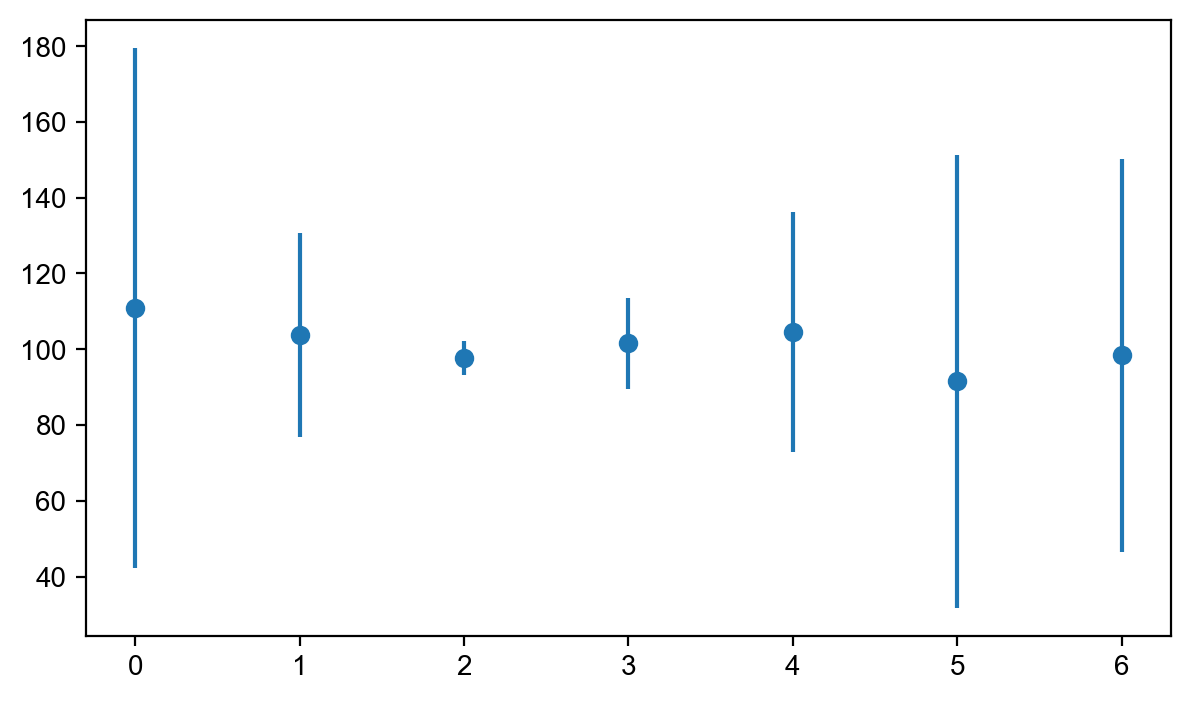

In [5]:
fig, ax = plt.subplots(figsize=(7,4))

ax.errorbar(x=range(len(uPops)), y=hornLen.mean().values, yerr=hornLen.std().values, marker='o', linestyle='none'); # note that adding the ';' removes the output text

Or do they...?

#### What's problematic with these graphs?
- Lines connect the points
    - Connections between points imply causal relationships, such as time or addition of an experimental treatment (e.g., drug dosage). Lines are not appropriate for groups like these, that are assumed independent sets for comparison.
- Axes
    - These do not show a 0 and don't have bounds above and below
    - No labels
    - No thought has been given on the axes *scale*

What about a bar chart? They start at 0 and go up.

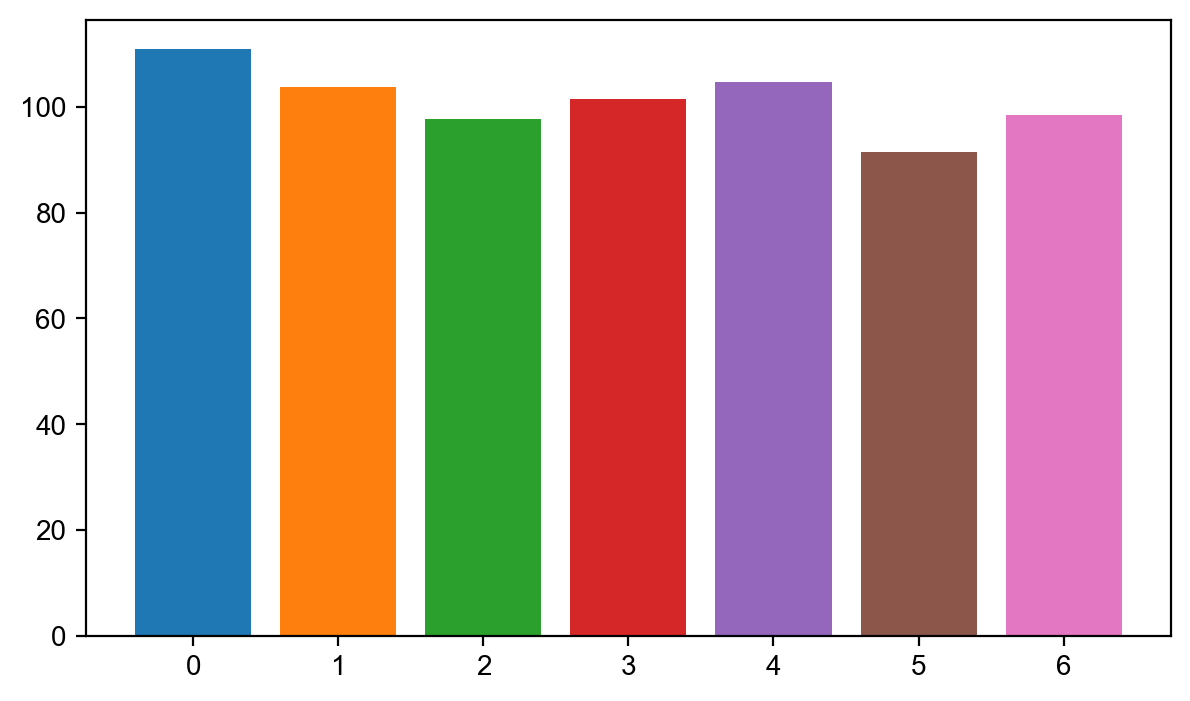

In [6]:
fig, ax = plt.subplots(figsize=(7,4))

for i,d in enumerate(uPops):
    ax.bar(x=i, height=hornLen[d].mean());

This is an improvement, but it still obscures what the underlying data look like. Are we supposed to assume they're all nice and neat normal distributions? 

Let's switch to plots that inherently show distribution features: box and whiskey and violin plots.

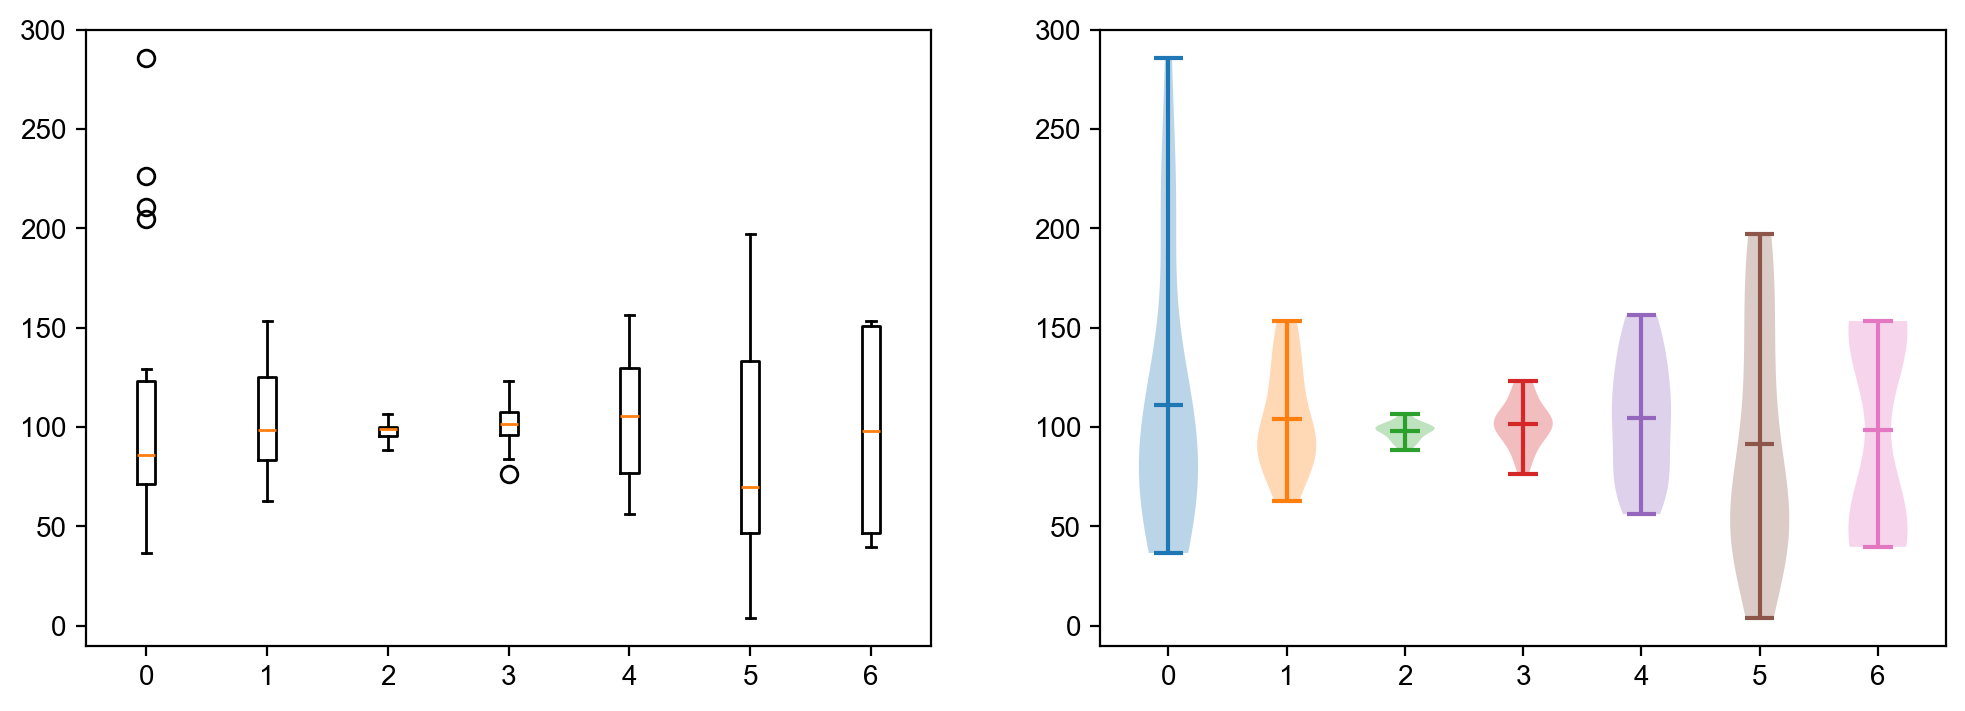

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i,d in enumerate(uPops):
    ax[0].boxplot(x=hornLen[d], positions=[i])
    ax[1].violinplot(dataset=hornLen[d], positions=[i], showmeans=True);

The box and whisker plot (left) shows the median (orange), interquartile range (box), 1.5X the interquartile range (whiskers), and flier points (any outside the whiskers). 

The violin plot (right) shows the mean (center line) and range (whiskers), while the violin background shows a kernel density estimation; i.e., a smoothed representation of where the underlying data are.

I like both plots, and generally prefer to show medians (and quartiles) because they are often more handy when working with non-normal data, but the kernel density of the violin plots is a very efficient way to visualize the underlying data. Another way of doing this is to simply layer the box and whiskey plots over scatter plots of the data. Since the range of each population's data is arbitrary, I'll randomly jitter the points to reduce their overlap.

In [8]:
def rand_jitter(arr, stdev=0.025):
    '''https://stackoverflow.com/questions/8671808/avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot'''
    return arr + np.random.randn(len(arr)) * stdev

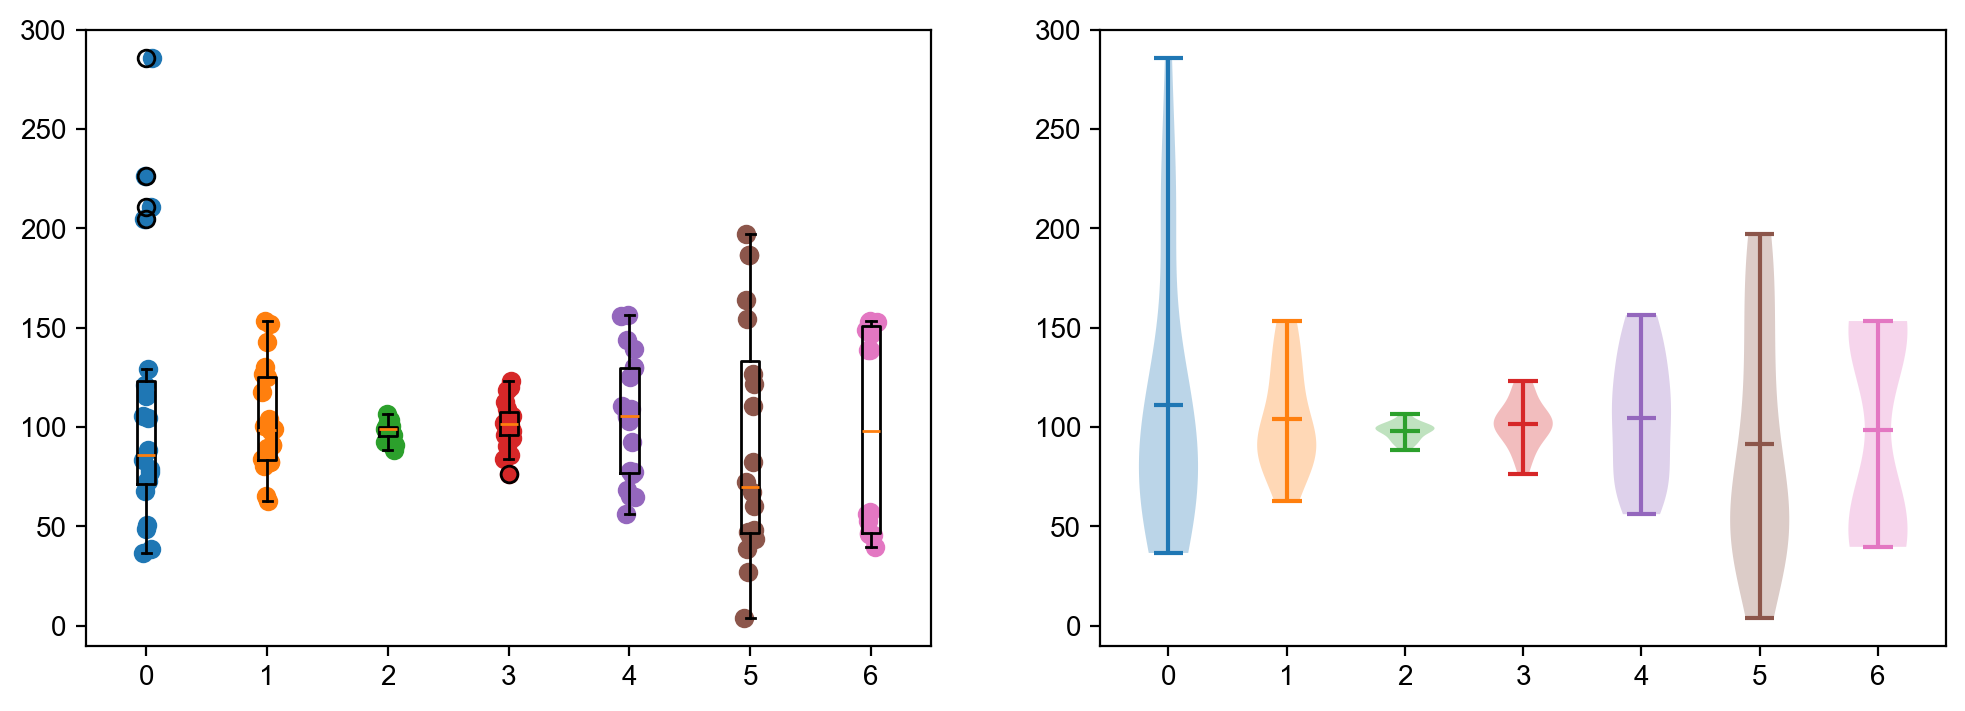

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i,d in enumerate(uPops):
    ax[0].boxplot(x=hornLen[d], positions=[i])
    ax[0].scatter(x=rand_jitter([i]*len(hornLen)), y=hornLen[d])
    ax[1].violinplot(dataset=hornLen[d], positions=[i], showmeans=True);

Let's clean this up a little bit...

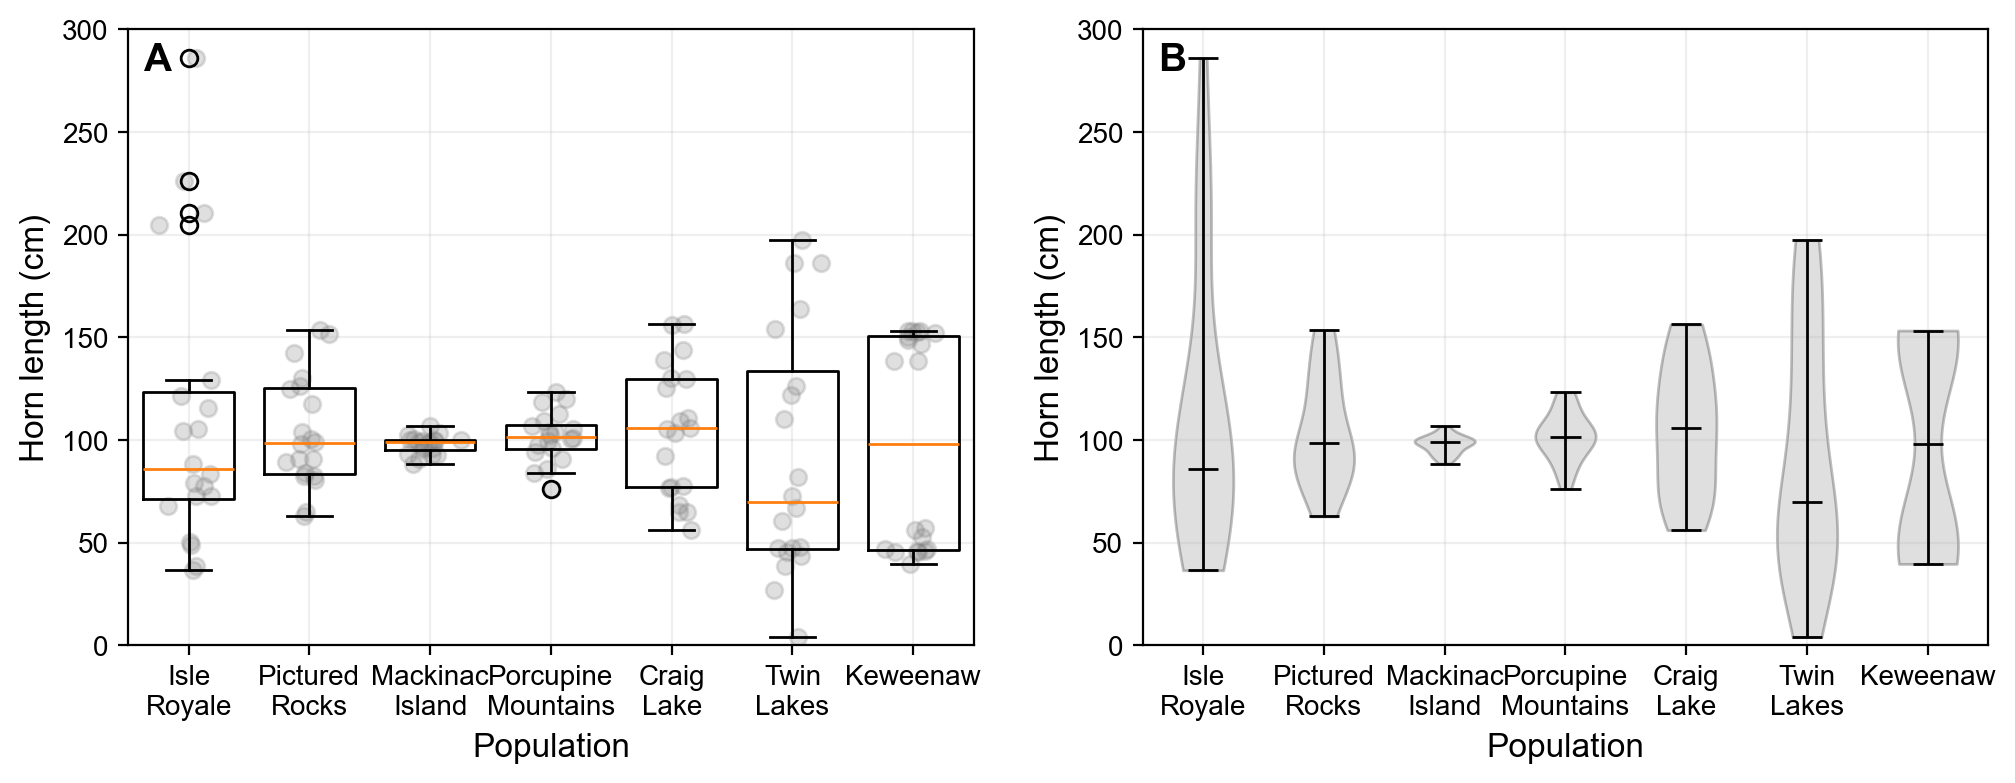

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i,d in enumerate(uPops):
    ax[0].boxplot(x=hornLen[d], positions=[i], widths=[0.75], )
    ax[0].scatter(x=rand_jitter([i]*len(hornLen), stdev=0.1), y=hornLen[d], alpha=0.25, color="grey")
    v = ax[1].violinplot(dataset=hornLen[d], positions=[i], showmedians=True,)
    for i, pc in enumerate(v['bodies']): 
        pc.set_facecolor('grey')
        pc.set_alpha(0.25)
        pc.set_edgecolor('black') 

    for partname in ('cbars', 'cmins', 'cmaxes','cmedians'): 
        vp = v[partname] 
        vp.set_edgecolor('black') 
        vp.set_linewidth(1)
        
# plt.violinplot()
for i in [0,1]:
    ax[i].grid(alpha=0.2)
    ax[i].set_xticks(range(7))
    ax[i].set_xticklabels([s.replace(" ", "\n") for s in hornLen])
    ax[i].set_xlim(-0.5, 6.5)
    ax[i].set_xlabel("Population", size=12)
    
    ax[i].set_yticks(np.arange(0,350,50))
    ax[i].set_ylim(0,300)
    ax[i].set_ylabel("Horn length (cm)", size=12)

    ax[i].text(0.035, 0.95, string.ascii_uppercase[i], transform=ax[i].transAxes, 
               weight="bold", fontsize=14, ha='center', va='center')

One more thing: `tight_layout`!

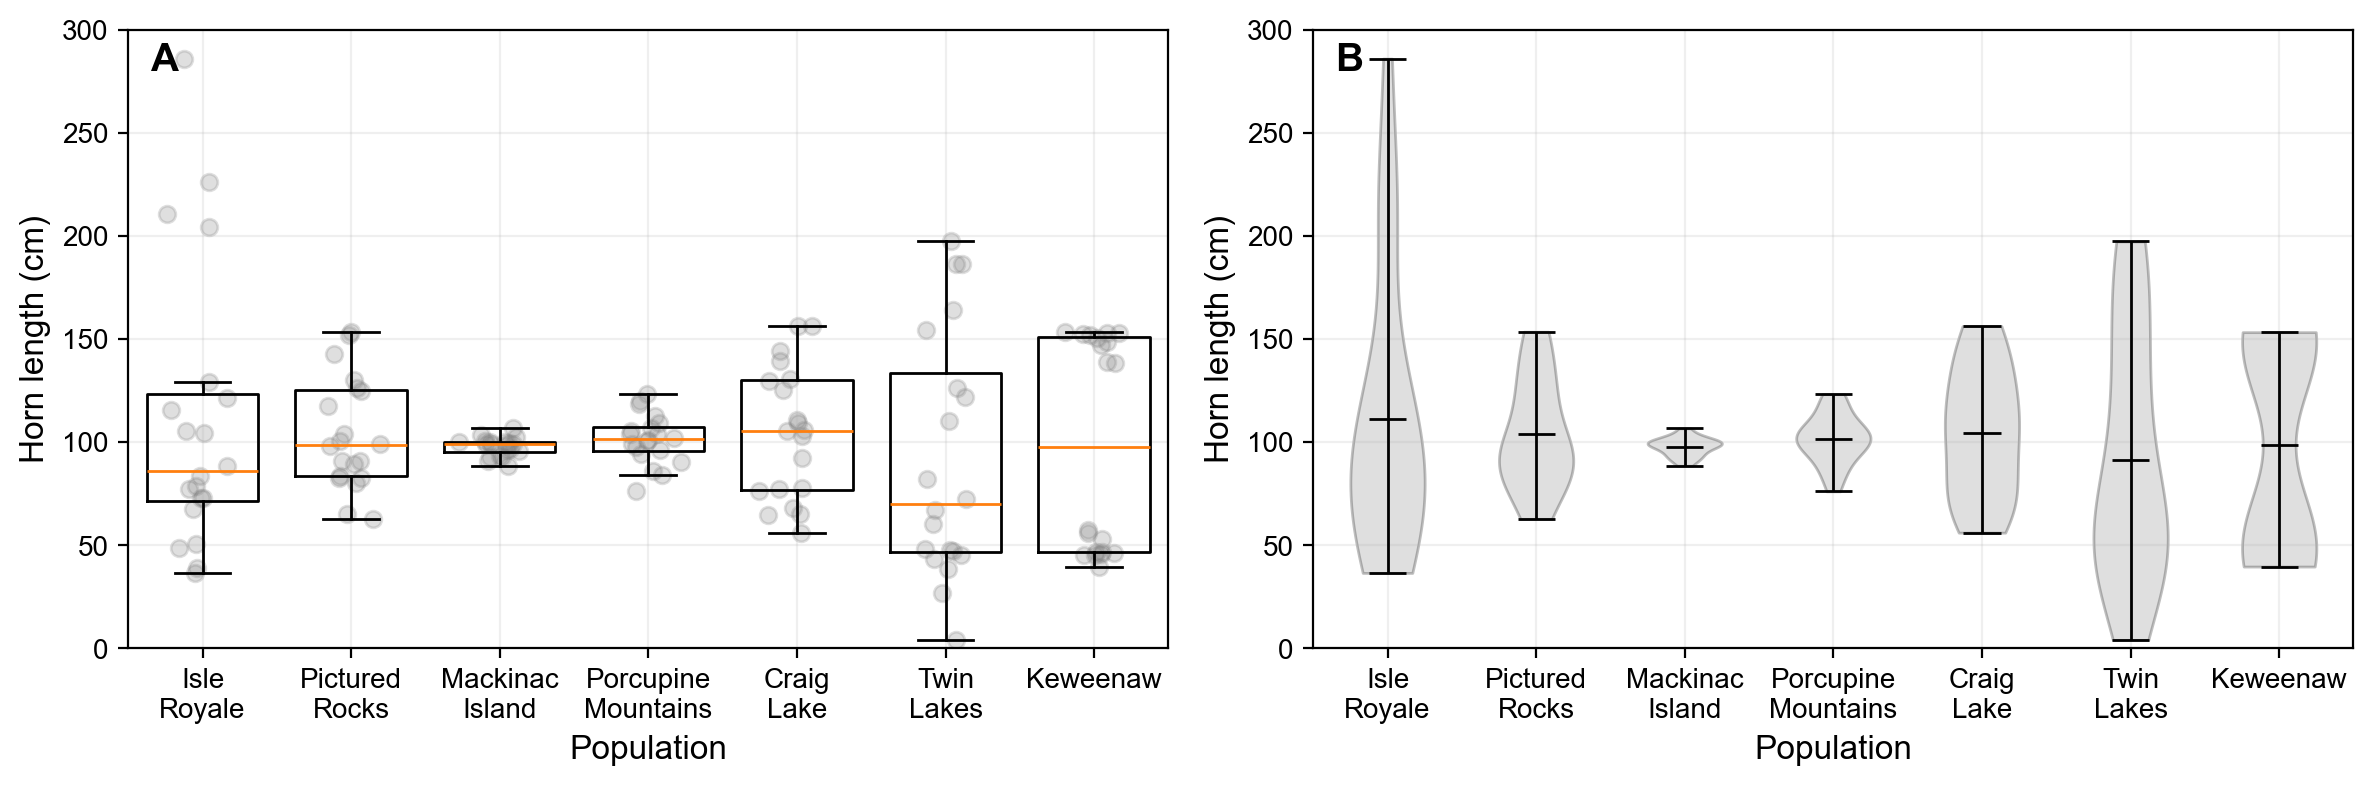

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i,d in enumerate(uPops):
    ax[0].boxplot(x=hornLen[d], positions=[i], widths=[0.75], showfliers=False)
    ax[0].scatter(x=rand_jitter([i]*len(hornLen), stdev=0.1), y=hornLen[d], alpha=0.25, color="grey")
    v = ax[1].violinplot(dataset=hornLen[d], positions=[i], showmeans=True,)
    for i, pc in enumerate(v['bodies']): 
        pc.set_facecolor('grey')
        pc.set_alpha(0.25)
        pc.set_edgecolor('black') 

    for partname in ('cbars', 'cmins', 'cmaxes','cmeans'): 
        vp = v[partname] 
        vp.set_edgecolor('black') 
        vp.set_linewidth(1)
        
# plt.violinplot()
for i in [0,1]:
    ax[i].grid(alpha=0.2)
    ax[i].set_xticks(range(7))
    ax[i].set_xticklabels([s.replace(" ", "\n") for s in hornLen]) # sub " " for the unicode newline character "\n"
    ax[i].set_xlim(-0.5, 6.5)
    ax[i].set_xlabel("Population", size=12)
    
    ax[i].set_yticks(np.arange(0,350,50))
    ax[i].set_ylim(0,300)
    ax[i].set_ylabel("Horn length (cm)", size=12)

    ax[i].text(0.035, 0.95, string.ascii_uppercase[i], transform=ax[i].transAxes, 
               weight="bold", fontsize=14, ha='center', va='center')
    
plt.tight_layout()

Ooooh that's a pretty nice plot (at least I think so).

#### Improvements
- Axes and axes ticks have labels with readable font sizes (journals generally specify fonts $\geq$ 8 pt).
    - _Note: plots should use sans serif fonts_
    - Subplots are labeled '**A**' and '**B**'
        - This is done using `transform=ax[i].transAxes`, which converts the axes from their original bound to `[0,1]`, which makes uniformly placing things like subplot labels convenient
- Removed "fliers" from box plots because they plot the same points twice
- Distributions with meaningful metrics (median, IQR, etc) are displayed along with more accurate representations of the the underlying data.
    - This shows how different the populations are despite looking very similar when plotting only the mean
- Style
    - I often like a light grid line to help me infer and compare values, especially across long plots
    - Colors can be pretty, but you generally should't use more than you need, and keeping them grey scale is a good default to ensure they're understandable by people with different vision or who may be printing them with our old lab printer (RIP)
    - I _almost_ always use `plt.tight_layout`, which more efficiently spaces and expands the plots; it cleans up things like overlapping axes ticks and labels
    - Python recognizes unicode symbols like tab (`\t`) and newline (`\n`), which allow you to improve the spacing of text (e.g., the x-tick labels)

#### Take aways
- _**Always**_ label axes and tick marks with easily readable text
- _**Always**_ think carefully about axes scales and _**generally**_ include 0
- _**Never**_ connect data that do not have causal or temporal relationships

#### Saving plots
**A quick aside:**
Plots saved in Python have high fidelity to how they appear on your screen and it's really easy to specify the type, quality, and background transparency. 
- Using some form of subplots and `tight_layout` will ensure your plots look pretty every time.
- `bbox_inches="tight"` will reduce white space around the edges
- `transparent=True` sets the background transparent, which I generally do just incase I want to use it on a white background

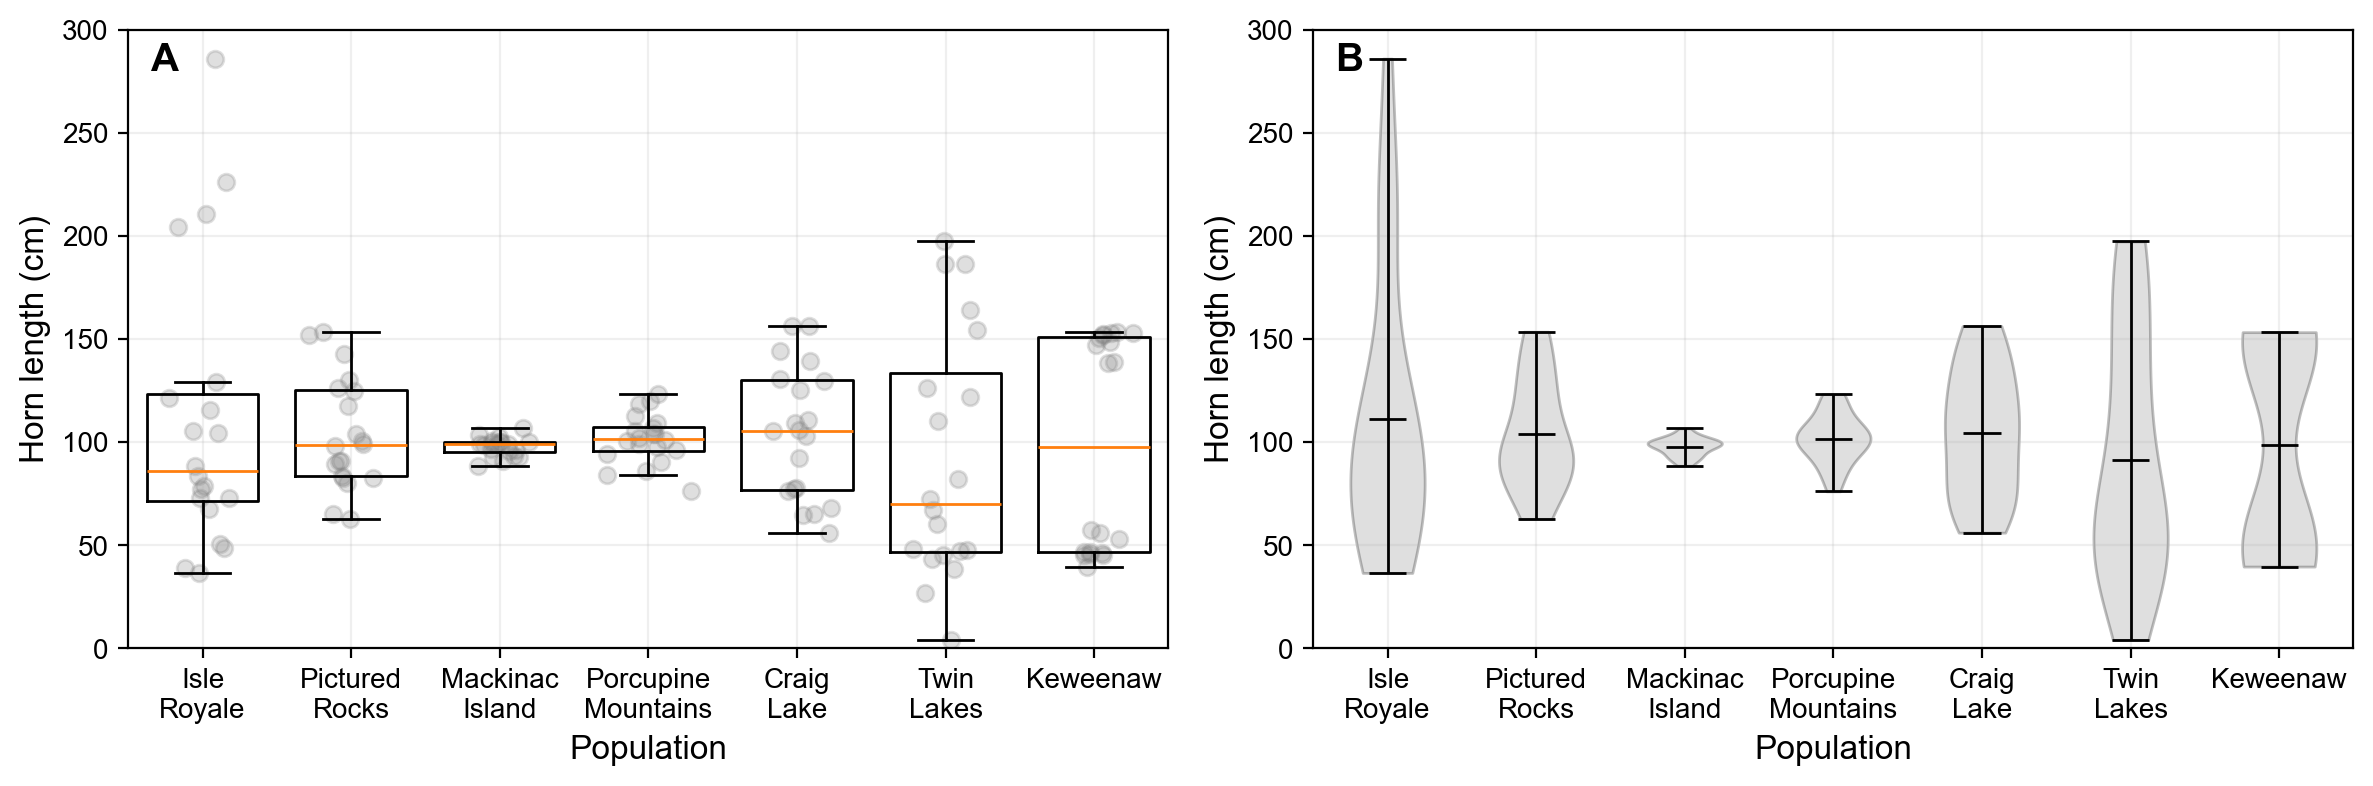

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i,d in enumerate(uPops):
    ax[0].boxplot(x=hornLen[d], positions=[i], widths=[0.75], showfliers=False)
    ax[0].scatter(x=rand_jitter([i]*len(hornLen), stdev=0.1), y=hornLen[d], alpha=0.25, color="grey")
    v = ax[1].violinplot(dataset=hornLen[d], positions=[i], showmeans=True,)
    for i, pc in enumerate(v['bodies']): 
        pc.set_facecolor('grey')
        pc.set_alpha(0.25)
        pc.set_edgecolor('black') 

    for partname in ('cbars', 'cmins', 'cmaxes','cmeans'): 
        vp = v[partname] 
        vp.set_edgecolor('black') 
        vp.set_linewidth(1)
        
# plt.violinplot()
for i in [0,1]:
    ax[i].grid(alpha=0.2)
    ax[i].set_xticks(range(7))
    ax[i].set_xticklabels([s.replace(" ", "\n") for s in hornLen])
    ax[i].set_xlim(-0.5, 6.5)
    ax[i].set_xlabel("Population", size=12)
    
    ax[i].set_yticks(np.arange(0,350,50))
    ax[i].set_ylim(0,300)
    ax[i].set_ylabel("Horn length (cm)", size=12)

    ax[i].text(0.035, 0.95, string.ascii_uppercase[i], transform=ax[i].transAxes, 
               weight="bold", fontsize=14, ha='center', va='center')
    
plt.tight_layout()
plt.savefig("../Figures/Unicorn-Horn-Length.pdf", format="pdf", dpi=150, transparent=True, bbox_inches="tight")

## 2. Styling and how to avoid misleading readers

Unfortunately, due to climate change and centuries of unicorn hunting for their life-prolonging blood, unicorn populations have precipitously declined from their historic averages based on the fossil record.

First, I'll generate a dataset of the magical activities of unicorn blood (in yrs added/mL) from 20 individuals in each population.

In [13]:
np.random.seed(9999)
baMeans = np.concatenate([np.random.exponential(1, size=2),np.random.exponential(0.1, size=2), np.random.exponential(0.001, size=3)])
baDists = []
for bam in baMeans:
    baDists.append(sorted(np.abs(np.random.normal(loc=bam, scale=np.sqrt(bam), size=20))))

bloodActivity = pd.DataFrame(baDists).T
bloodActivity.columns = uPops
bloodActivity.head()

Isle Royale  Pictured Rocks  Mackinac Island  Porcupine Mountains  \
0     0.066030        0.014198         0.001133             0.017570   
1     0.154083        0.073519         0.003328             0.043204   
2     0.274649        0.120865         0.003904             0.058625   
3     0.390067        0.121515         0.007049             0.068967   
4     0.484124        0.151024         0.007288             0.087857   

   Craig Lake  Twin Lakes  Keweenaw  
0    0.000074    0.001175  0.002438  
1    0.000107    0.002776  0.007674  
2    0.001108    0.003729  0.010286  
3    0.001323    0.004536  0.012641  
4    0.001405    0.006397  0.013902

Next, I'll generate data on the effective population sizes of each population, taken every 5 years for the past 100 years.

In [14]:
np.random.seed(9999)
psMeans = np.concatenate([np.random.exponential(10, size=2),np.random.exponential(100, size=2), np.random.exponential(1000, size=3)])
psDists = []
for psm in psMeans:
    dist = np.abs(np.random.normal(loc=psm, scale=np.sqrt(psm)/2, size=20))
    foo = np.random.choice([-1,0,1])
    if foo==0: # stable population
        dist = dist * 1
    elif foo==1: 
        dist = dist * ((np.arange(1,21,1)/100)+1)
    elif foo==-1: 
        dist = dist * (1 - (np.arange(1,21,1)/100))
    psDists.append(dist)
    
popSize = pd.DataFrame(psDists).T
popSize.columns = uPops
popSize.head()

Isle Royale  Pictured Rocks  Mackinac Island  Porcupine Mountains  \
0    17.132825        1.543417         4.142939            81.895074   
1    22.963430        2.326508         1.512869            82.078509   
2    19.338311        2.599354         4.240275            87.629889   
3    18.553029        1.728058         3.049877            80.661579   
4    16.559279        2.288717         4.796481            80.169421   

   Craig Lake  Twin Lakes    Keweenaw  
0  164.330811  206.263179  541.632925  
1  168.604407  210.599991  540.360929  
2  163.336668  208.991225  534.145400  
3  154.818665  204.617423  538.765508  
4  171.306596  210.174778  524.582350

Okay, let's first look at the blood activity with a box and whisket plot like we made above.

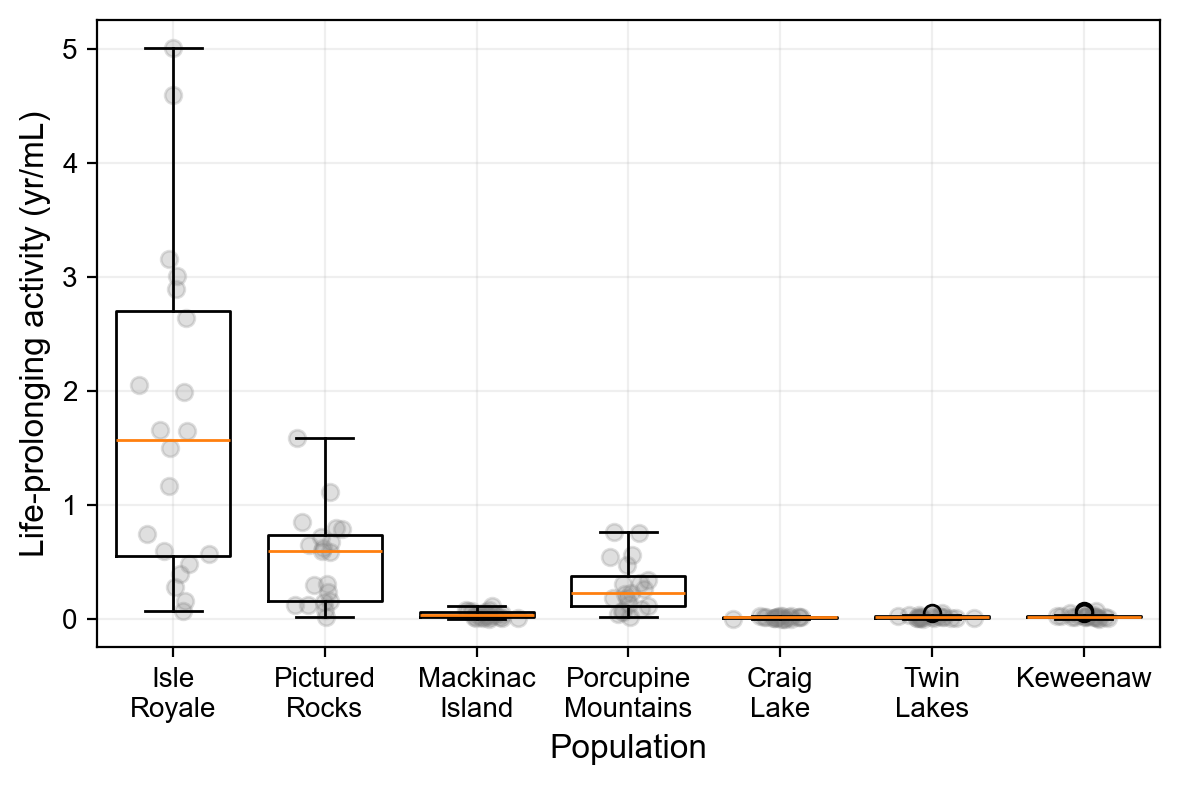

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for i,d in enumerate(uPops):
    ax.boxplot(x=bloodActivity[d], positions=[i], widths=[0.75])
    ax.scatter(x=rand_jitter([i]*len(bloodActivity), stdev=0.1), y=bloodActivity[d], alpha=0.25, color="grey")

ax.grid(alpha=0.2)
ax.set_xticks(range(7))
ax.set_xticklabels([s.replace(" ", "\n") for s in hornLen])
ax.set_xlim(-0.5, 6.5)
ax.set_xlabel("Population", size=12)
ax.set_ylabel("Life-prolonging activity (yr/mL)", size=12)

plt.tight_layout()

We've hit a new problem: our data seem to span multiple orders of magnitude, which are obscured on a linear y-axis.

You can go a couple directions here: you could transform your data into a new data set and then show those on a linear axis, or you could leave them as is and transform the axis itself.

In [16]:
bloodActivityLog10 = np.log10(bloodActivity)

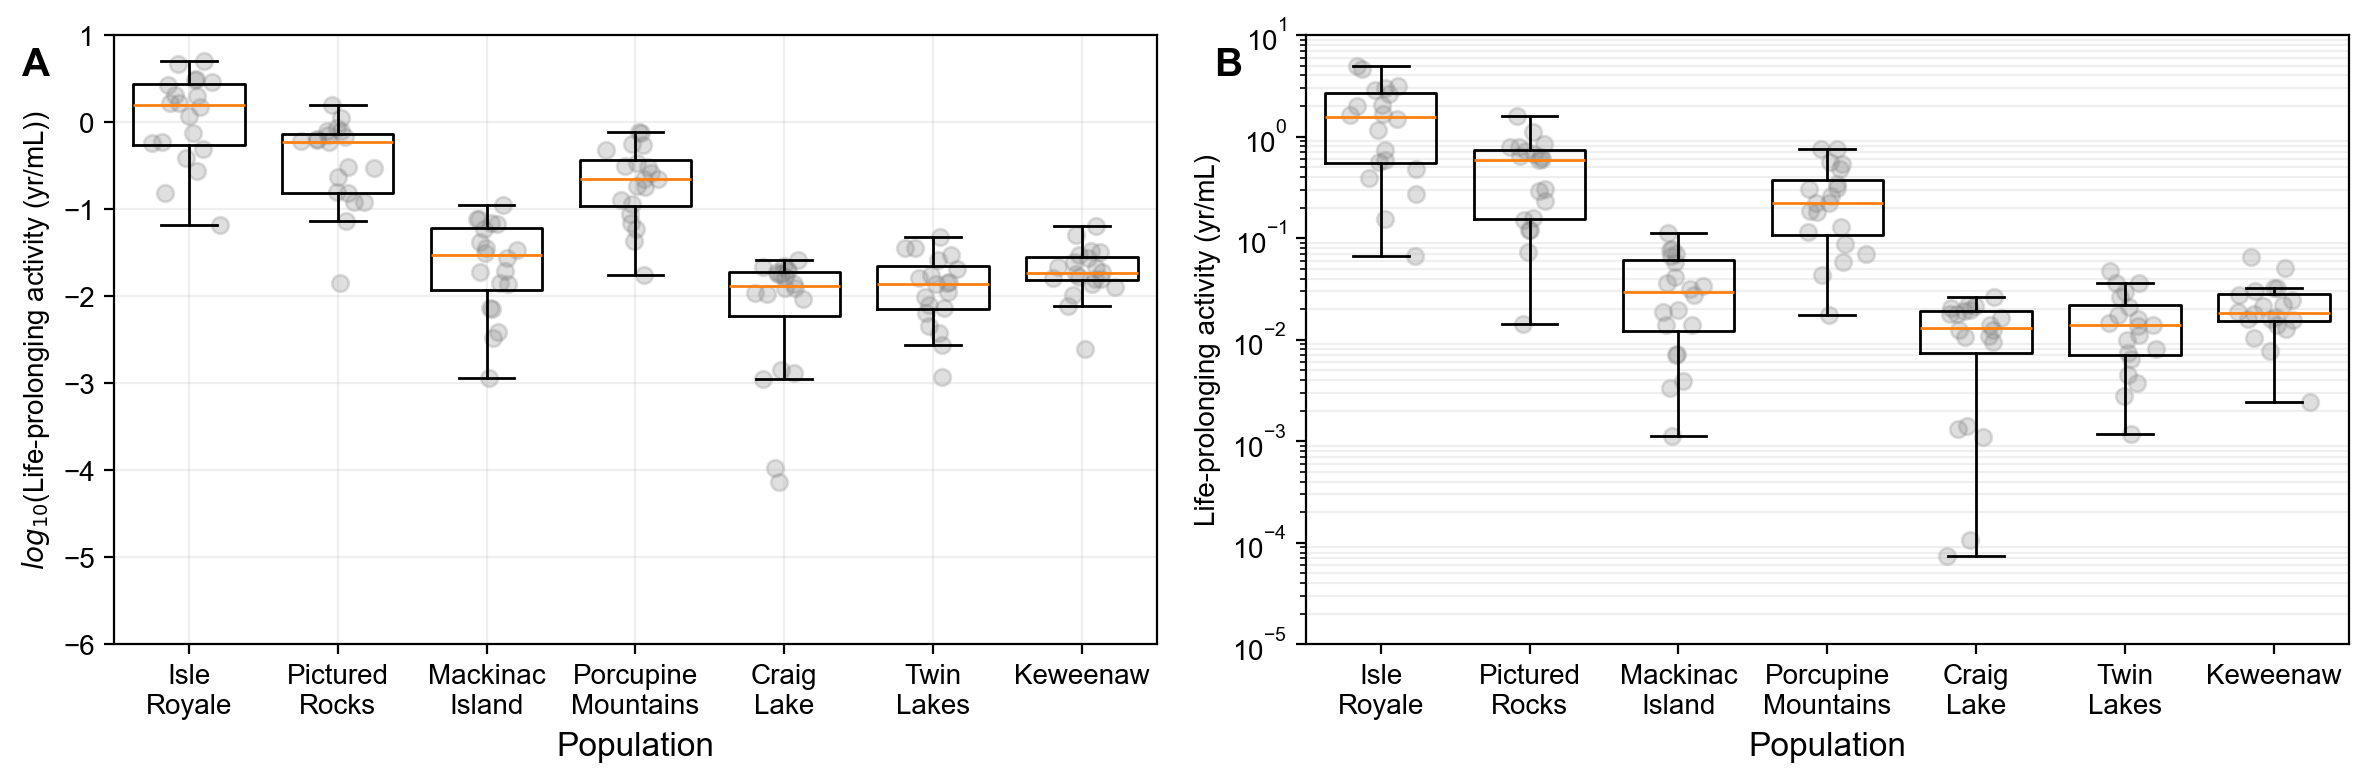

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for i,d in enumerate(uPops):
    ax[0].boxplot(x=bloodActivityLog10[d], positions=[i], widths=[0.75], showfliers=False)
    ax[0].scatter(x=rand_jitter([i]*len(bloodActivityLog10), stdev=0.1), y=bloodActivityLog10[d], alpha=0.25, color="grey")

    ax[1].boxplot(x=bloodActivity[d], positions=[i], widths=[0.75], showfliers=False)
    ax[1].scatter(x=rand_jitter([i]*len(bloodActivity), stdev=0.1), y=bloodActivity[d], alpha=0.25, color="grey")

for i in [0,1]:
    ax[i].set_xticks(range(7))
    ax[i].set_xticklabels([s.replace(" ", "\n") for s in hornLen])
    ax[i].set_xlim(-0.5, 6.5)
    ax[i].set_xlabel("Population", size=12)
    ax[i].text(-0.075, 0.95, string.ascii_uppercase[i], transform=ax[i].transAxes, 
               weight="bold", fontsize=14, ha='center', va='center')

ax[0].set_ylim(-6,1)
ax[1].set_ylim(10e-6, 10)

ax[0].grid(alpha=0.2, which='major')
ax[1].grid(alpha=0.2, which='minor')

ax[0].set_ylabel("$log_{10}$(Life-prolonging activity (yr/mL))", size=10)
ax[1].set_ylabel("Life-prolonging activity (yr/mL)", size=10)
ax[1].semilogy() # log transform y-axis

plt.tight_layout()

A few extra touches I added:
- In **A** I made sure the update the y-axis label to indicate that these are log-transformed values
    - Note the $log_{10}$ in **A**; you can use [LaTex math formatting](https://en.wikibooks.org/wiki/LaTeX/Mathematics) by bracking text in `$`'s
- In **B** I changed which grid lines are displayed to the `minor` gridlines, which show log-10 spaces increments, which I find useful because people are generally bad at visualizing distances in log-space. A benefit of this style is that it really shows how much distance is between points because there are so many lines between them.

I wonder if unicorn blood activity is related to horn length, perhaps because they could be linked due to selection on unicorns with both long horns and high life-prolonging effects.

Although some of these plots might feel contrived, they are examples of plot styles I've (unfortunately) seen in published papers.

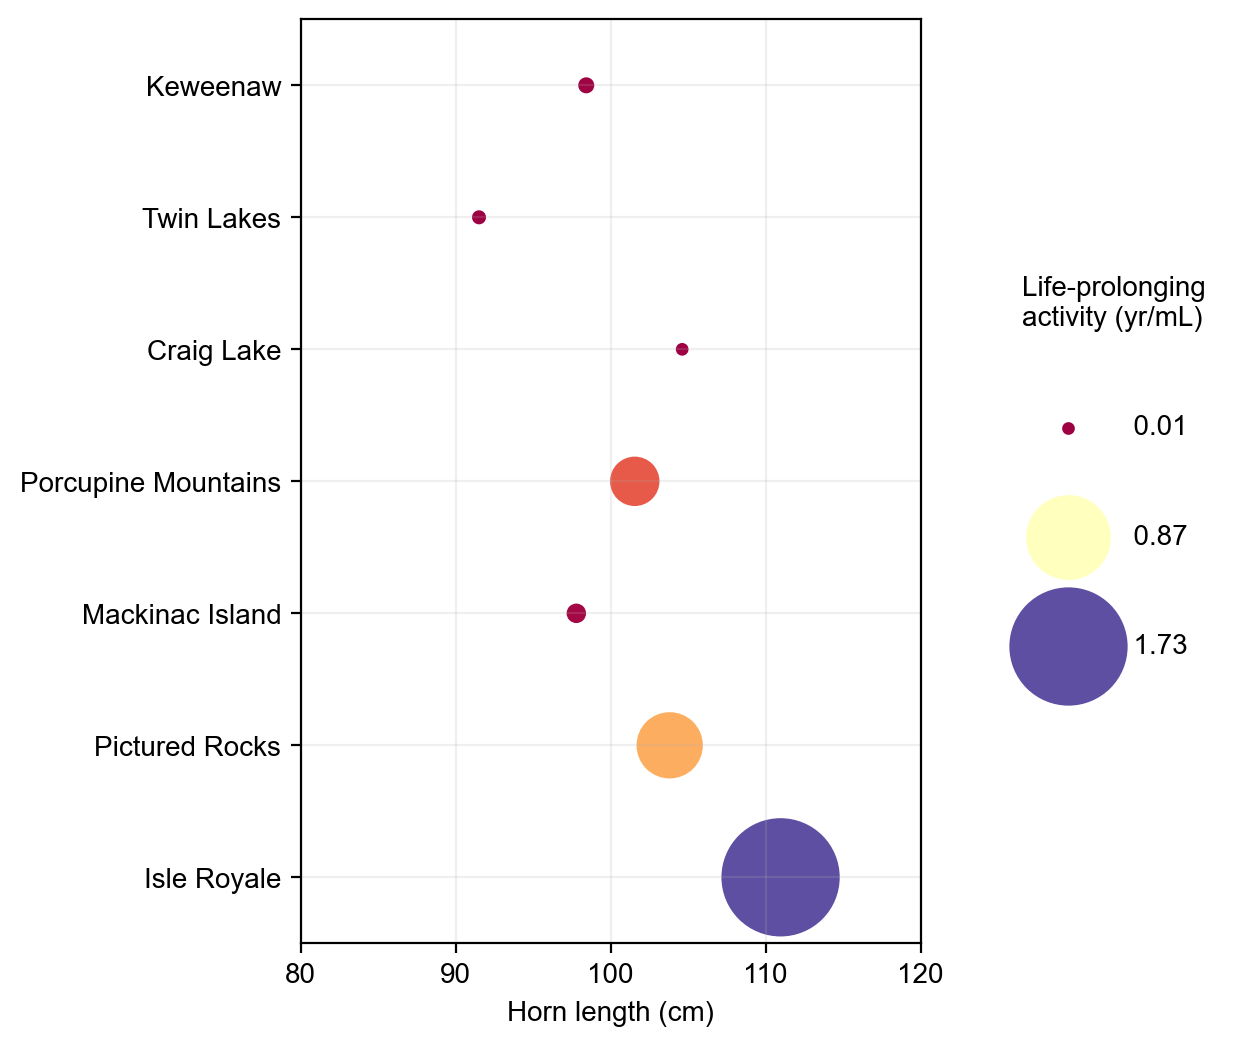

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,6))

# Create a custom color range using the Spectral colormap 
cmap = cm.Spectral
norm = plt.Normalize(bloodActivity.mean().min(), bloodActivity.mean().max()) 
myColors = cmap(norm(bloodActivity.mean()))

ax.scatter(x=hornLen.mean(), y=range(7), s=bloodActivity.mean()*1000, c=myColors)

# Define representative values for the legend 
sizes = np.linspace(bloodActivity.mean().min(), bloodActivity.mean().max(), 3) 
legend_sizes = sizes * 1000 
legend_colors = cmap(norm(sizes)) 
# Create scatter plots for legend 
legend_handles = [plt.scatter([], [], s=size, color=color, label=f'  {size/1000:.2f}') for size, color in zip(legend_sizes, legend_colors)]
# Add custom legend
ax.legend(handles=legend_handles, title='Life-prolonging\nactivity (yr/mL)',labelspacing=3, frameon=False, bbox_to_anchor=(1.5, 0.75))

ax.set_xlim(80,120)
ax.set_ylim(-0.5,6.5)
ax.grid(alpha=0.2)

ax.set_xlabel("Horn length (cm)")
ax.set_yticks(range(len(uPops)))
ax.set_yticklabels(uPops);

#### What's wrong with this?
- As mentioned above, humans are _very bad_ at log scales, so things like scaling points by area and color make them difficult to compare.
- Blood activity is scaled in _two_ ways, which makes values seem more different than they truly are.
- The bigger your marker, the more difficult it is to identify its value.
- The use of `Spectral` (a frequently used colormap) is problematic because it's a _diverging_ colormap. When using colors, ask yourself "Which colors do you _expect_ to reprepresent more similar/distance values?" This sort of colormap should only be used for visualizing data that diverge from a central value, not for values that extend on one side of an axis only.
    - [Matplotlib provides the following advice for using colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html#overview)
        - Sequential: change in lightness and often saturation of color incrementally, often using a single hue; should be used for representing information that has ordering.
        - Diverging: change in lightness and possibly saturation of two different colors that meet in the middle at an unsaturated color; should be used when the information being plotted has a critical middle value, such as topography or when the data deviates around zero.
        - Cyclic: change in lightness of two different colors that meet in the middle and beginning/end at an unsaturated color; should be used for values that wrap around at the endpoints, such as phase angle, wind direction, or time of day.
        - Qualitative: often are miscellaneous colors; should be used to represent information which does not have ordering or relationships.

_**Note**_ that I turned off `tight_layout` here, which can get upset when adding things (i.e., the legend) outside the plot margins. In cases like this, where I don't have room to add the legend directly on the plot, I prefer to make a second axis (covered below). You don't have to do this, but using `tight_layout` usually makes plot saving higher fidelity to what you see on the screen.

Let's go on a little tangent to use the different kinds of colormaps.

In [19]:
# Make some confusion matrix data
confmat = np.array([[0.6,0.3,0.1],[0.3,0.4,0.3],[0.1,0.1,0.8]])

In [20]:
# Random data on how hours spent watching Harry Potter
# and Twighlight affect belief in unicorns
np.random.seed(9999)
hph = np.random.normal(scale=1, size=1000)
tlh = np.random.normal(scale=1, size=1000)
Zhph = (hph - np.mean(hph)) / np.std(hph)
Ztlh = (tlh - np.mean(tlh)) / np.std(hph)
unicornBelief = Zhph+Ztlh

In [21]:
# Some data on unicorn horn spiral
hornAngle = hornLen.copy()
for pop in uPops:
    hornAngle[pop] = np.abs(hornAngle[pop]*np.random.normal(loc=1,scale=0.34,size=len(hornAngle))*(np.pi/180))

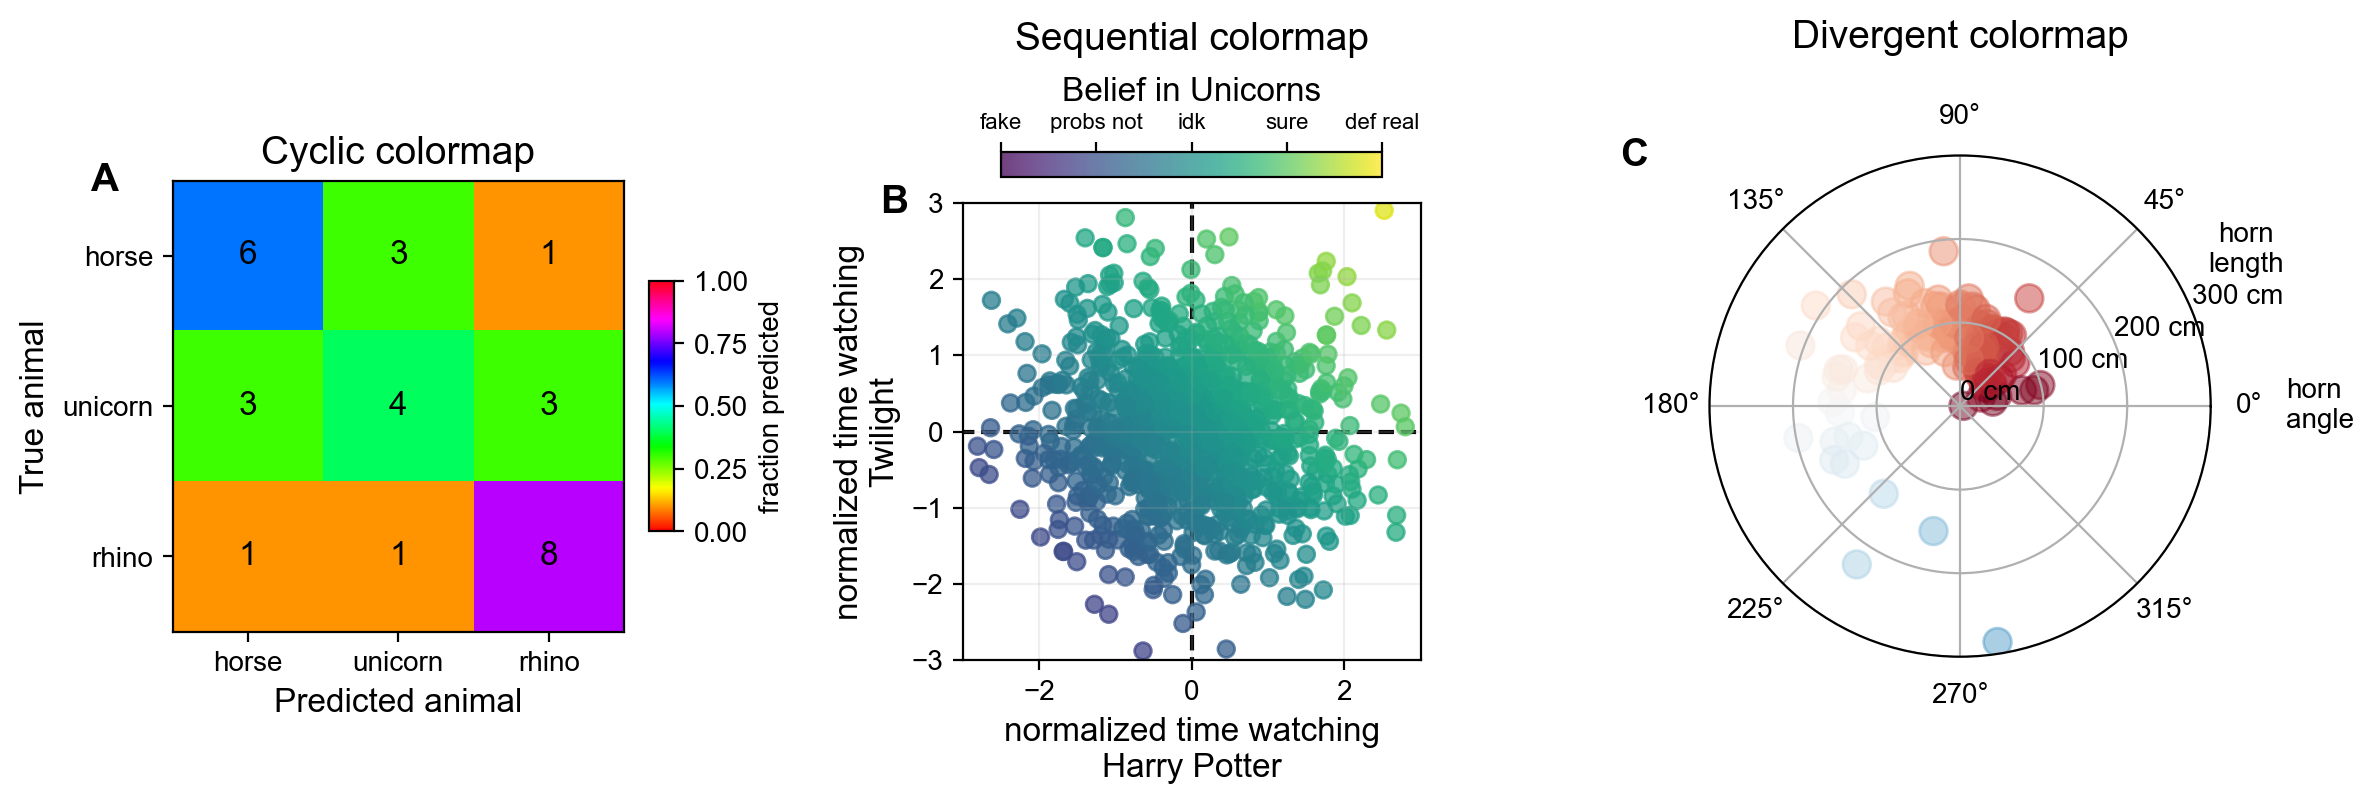

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

im = ax[0].imshow(confmat, cmap="hsv", vmin=0, vmax=1)
ax[0].set_xticks(range(3))
ax[0].set_yticks(range(3))
ax[0].set_xticklabels(["horse", "unicorn","rhino"])
ax[0].set_yticklabels(["horse", "unicorn","rhino"])
for i in range(len(confmat)):
    for j in range(len(confmat)):
        ax[0].text(j, i, int(confmat[i, j]*10), ha="center", va="center", color="black", size=12)

plt.colorbar(im, ax=ax[0], aspect=10, fraction=0.05, label="fraction predicted")
ax[0].set_xlabel("Predicted animal", size=12)
ax[0].set_ylabel("True animal", size=12)
ax[0].set_title("Cyclic colormap", size=14)

scatter = ax[1].scatter(x=Zhph, y=Ztlh, c=unicornBelief, cmap="viridis", alpha=0.75, vmin=-6, vmax=6)
ax[1].vlines(x=0, ymin=-10, ymax=10, linestyle="--", color="black", zorder=0)
ax[1].hlines(y=0, xmin=-10, xmax=10, linestyle="--", color="black", zorder=0)
ax[1].grid(alpha=0.2)
ax[1].set_xlabel("normalized time watching\nHarry Potter", size=12)
ax[1].set_ylabel("normalized time watching\nTwilight", size=12)
ax[1].set_title("Sequential colormap", size=14, pad=55)
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)

cbar01 = plt.colorbar(scatter, ax=ax[1], aspect=15, fraction=0.05, orientation="horizontal", location="top")
cbar01.set_ticks(np.arange(-6,9,3))
cbar01.set_ticklabels(["fake", "probs not", "idk", "sure", "def real"], size=8)
cbar01.set_label("Belief in Unicorns",size=12)

ax[2].axis('off')
ax[2] = plt.subplot(1,3,3, projection='polar')
for pop in uPops:
    ax[2].scatter(x=hornAngle[pop], y=hornLen[pop], marker="o", linestyle="", alpha=0.5, 
                  c=hornAngle[pop], cmap="RdBu",s=100, vmin=0, vmax=2*np.pi)
ax[2].set_yticks(np.arange(0,400,100))
ax[2].set_yticklabels(["{} cm".format(x) for x in np.arange(0,400,100)])
ax[2].set_title("Divergent colormap", size=14, pad=20)
ax[2].text(0,390, "horn\nangle", va='center')
ax[2].text(0.5,390, "horn\nlength", va='center', ha='center')

for i in range(3):
    ax[i].set_aspect('equal', 'box') # make axes square
    ax[i].text(-0.15, 1, string.ascii_uppercase[i], transform=ax[i].transAxes, 
            weight="bold", fontsize=14, ha='center', va='center')

plt.tight_layout()

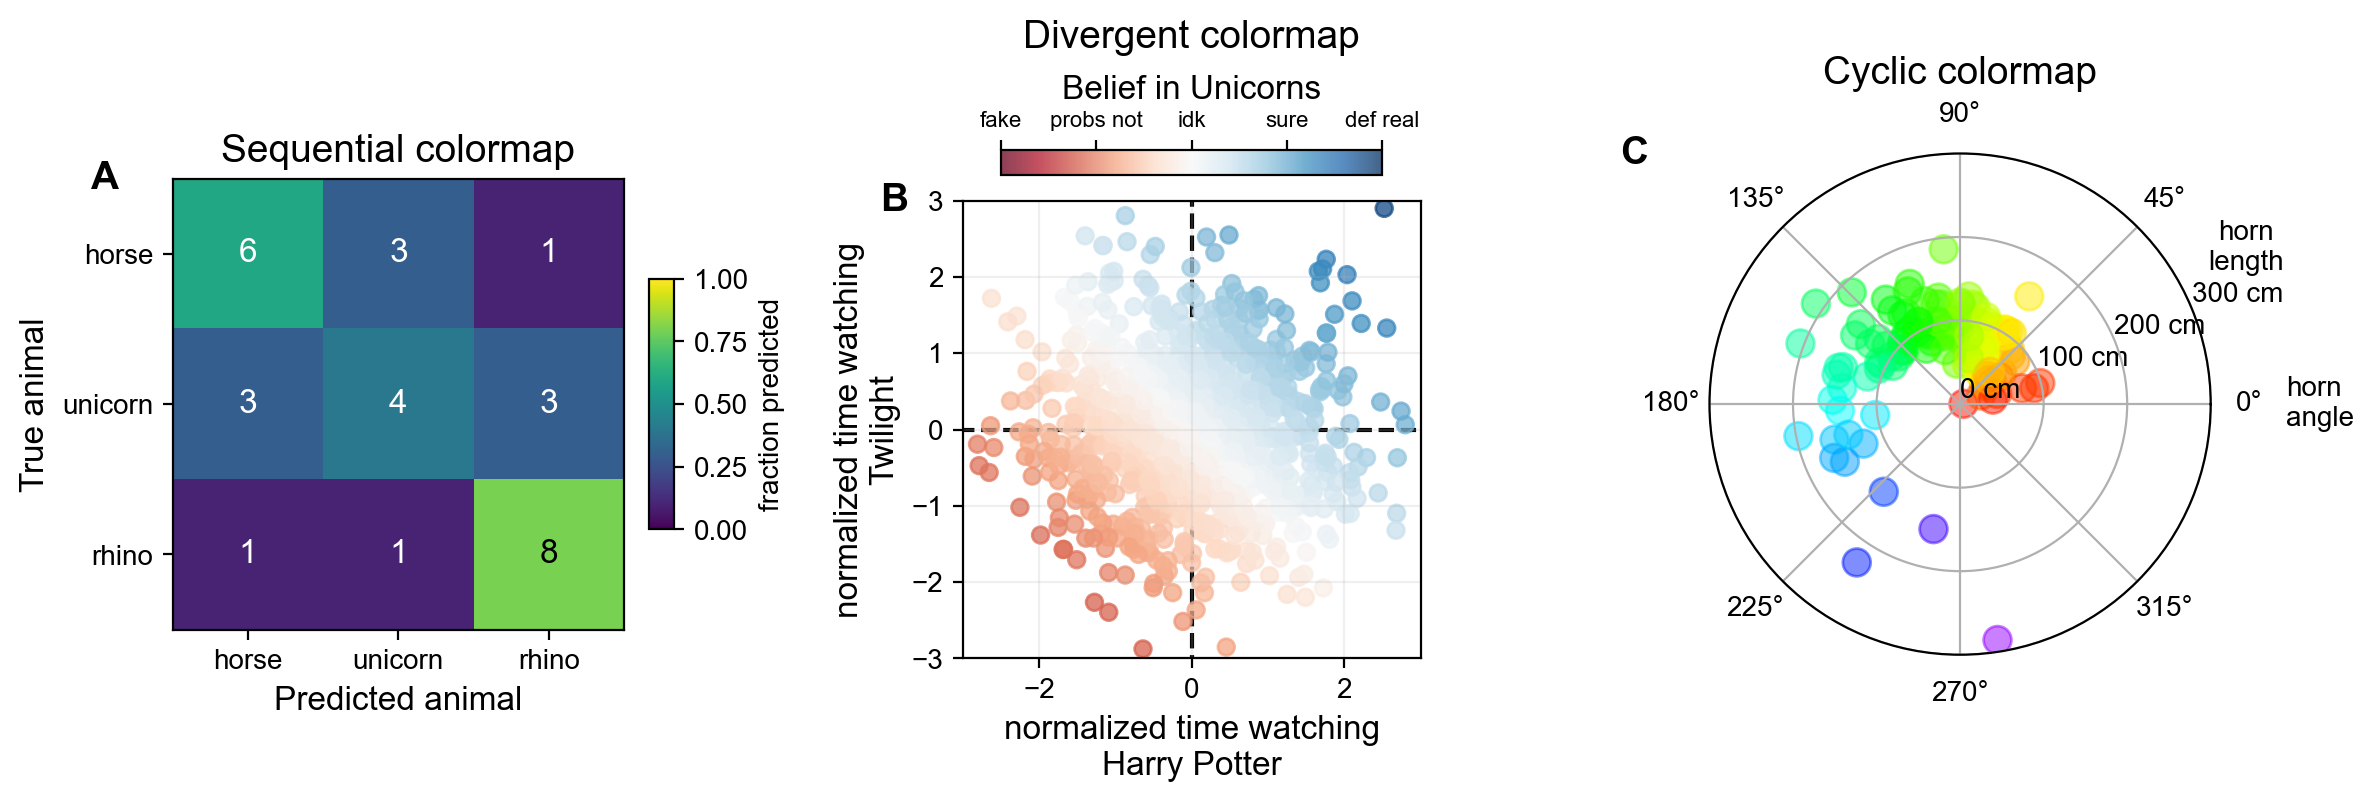

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

im = ax[0].imshow(confmat, cmap="viridis", vmin=0, vmax=1)
ax[0].set_xticks(range(3))
ax[0].set_yticks(range(3))
ax[0].set_xticklabels(["horse", "unicorn","rhino"])
ax[0].set_yticklabels(["horse", "unicorn","rhino"])
for i in range(len(confmat)):
    for j in range(len(confmat)):
        if confmat[i, j] > 0.75: color = "black"
        else: color="white"
        ax[0].text(j, i, int(confmat[i, j]*10), ha="center", va="center", color=color, size=12)

plt.colorbar(im, ax=ax[0], aspect=10, fraction=0.05, label="fraction predicted")
ax[0].set_xlabel("Predicted animal", size=12)
ax[0].set_ylabel("True animal", size=12)
ax[0].set_title("Sequential colormap", size=14)
# Set the axis to be square
ax[0].set_aspect('equal', 'box')

scatter = ax[1].scatter(x=Zhph, y=Ztlh, c=unicornBelief, cmap="RdBu", alpha=0.75, vmin=-6, vmax=6)
ax[1].vlines(x=0, ymin=-10, ymax=10, linestyle="--", color="black", zorder=0)
ax[1].hlines(y=0, xmin=-10, xmax=10, linestyle="--", color="black", zorder=0)
ax[1].grid(alpha=0.2)
ax[1].set_xlabel("normalized time watching\nHarry Potter", size=12)
ax[1].set_ylabel("normalized time watching\nTwilight", size=12)
ax[1].set_title("Divergent colormap", size=14, pad=55)
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)

# Set the axis to be square
cbar01 = plt.colorbar(scatter, ax=ax[1], aspect=15, fraction=0.05, orientation="horizontal", location="top")
cbar01.set_ticks(np.arange(-6,9,3))
cbar01.set_ticklabels(["fake", "probs not", "idk", "sure", "def real"], size=8)
cbar01.set_label("Belief in Unicorns",size=12)

ax[2].axis('off')
ax[2] = plt.subplot(1,3,3, projection='polar')
for pop in uPops:
    ax[2].scatter(x=hornAngle[pop], y=hornLen[pop], marker="o", linestyle="", alpha=0.5, 
                  c=hornAngle[pop], cmap="hsv", s=100, vmin=0, vmax=2*np.pi)
ax[2].set_yticks(np.arange(0,400,100))
ax[2].set_yticklabels(["{} cm".format(x) for x in np.arange(0,400,100)])
ax[2].set_title("Cyclic colormap", size=14, pad=25)
ax[2].text(0,390, "horn\nangle", va='center')
ax[2].text(0.5,390, "horn\nlength", va='center', ha='center')

for i in range(3):
    ax[i].set_aspect('equal', 'box') # make axes square
    ax[i].text(-0.15, 1, string.ascii_uppercase[i], transform=ax[i].transAxes, 
            weight="bold", fontsize=14, ha='center', va='center')

plt.tight_layout()

oooooookkkkaaayyy now back to our horn length-blood activity relationship!

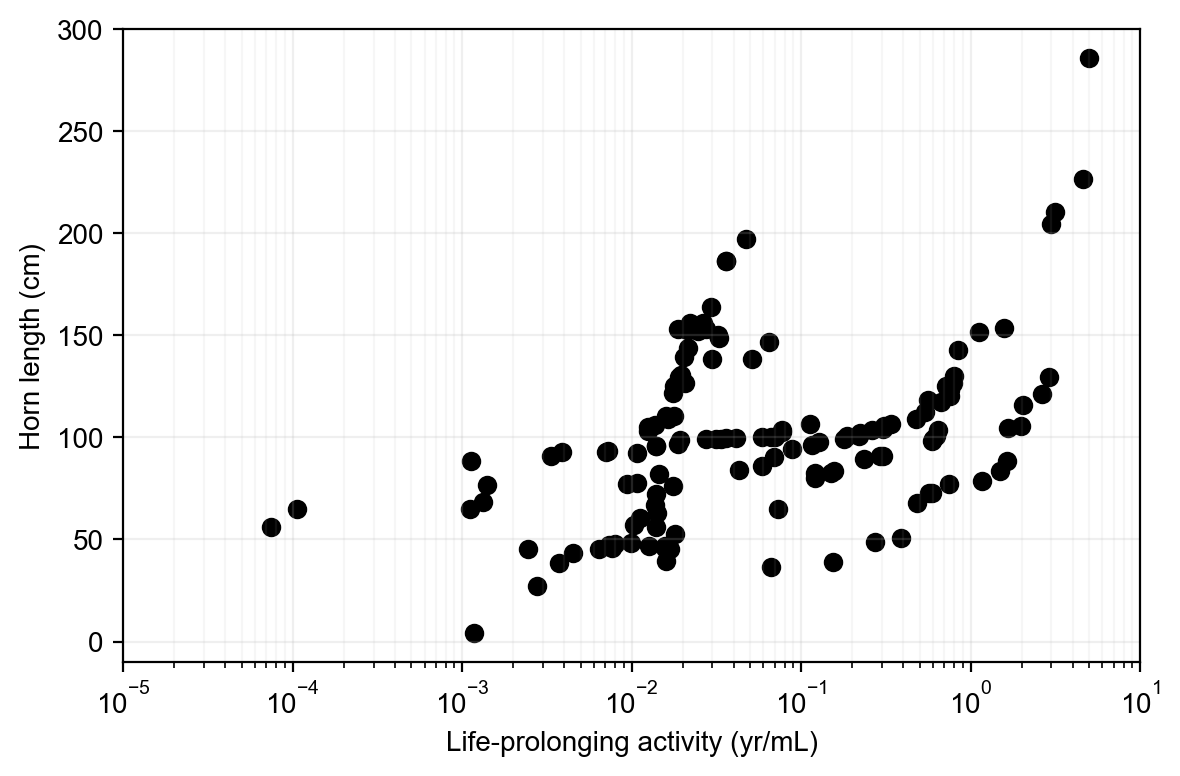

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for i,pop in enumerate(uPops):
    ax.scatter(x=bloodActivity[pop], y=hornLen[pop], color="black")

ax.semilogx()
ax.grid(alpha=0.2, which='major')
ax.grid(alpha=0.1, which='minor', axis='x')

ax.set_xlim(10e-6,10)
ax.set_ylim(-10,300)

ax.set_xlabel("Life-prolonging activity (yr/mL)")
ax.set_ylabel("Horn length (cm)")

plt.tight_layout()

Are we cool with this?

I'd say no, for a few reasons
- Combining axes that have different scales is generally a no-no because it warps your sense of distance
- Generally, we use the domain (x-axis) to describe or predict the range (y-axis). While we're only thinking about correlation here, I'd assume that _in practice_ one would like to use an easy measurement (horn length) to predict a more difficult measure (blood activity). For this reason, we should flip the axes.

Let's make these adjustments and also see is there is, in fact, a correlation between these two features.

In [25]:
import statsmodels.api as sm

In [26]:
def flatten(lol):
    return [item for sublist in lol for item in sublist]

Sometimes there exist data transformations or scaling that make the data much more intuitive. It's worth taking some time to think about what you want your reader to take away. For example, in this case, I think it's difficult to interpret how long 0.01 yrs added per mL unicorn blood, but 3.65 days/mL is easier to grasp.

In [27]:
hlba = hornLen.melt(value_vars=uPops,)
hlba.columns = ["Population", "Horn Length (cm)"]
hlba = hlba.join(bloodActivity.melt(value_vars=uPops).drop(["variable"], axis=1))
hlba["log10 Blood Activity (d/mL)"] = np.log10(365*hlba['value'])
hlba.drop(["value"], axis=1, inplace=True)
hlba["Individual"] = np.tile(np.arange(1,21),7)
hlba.head()

Population  Horn Length (cm)  log10 Blood Activity (d/mL)  Individual
0  Isle Royale         36.552388                     1.382032           1
1  Isle Royale         38.745385                     1.750049           2
2  Isle Royale         48.619956                     2.001070           3
3  Isle Royale         50.529259                     2.153432           4
4  Isle Royale         67.702317                     2.247249           5

After log10-transforming, I think it's easier to put $10^{2.73}$ d/mL in context (somewhere between 500 and 1000 days) rather than $10^{0.175}$ yr/mL.

You might be surprised how often I hear something along the lines of, "Python may be good at X, but you can't use it for statistics like R". **Not true!** `statsmodels` is very user-friendly package that can be applied to many statistical frameworks and I'll use it here to assess the predictive power of horn length on blood activity.

In [28]:
y = hlba["log10 Blood Activity (d/mL)"]
X = hlba["Horn Length (cm)"]
# add constant
X = sm.add_constant(X)
# fit model
model = sm.OLS(y,X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     log10 Blood Activity (d/mL)   R-squared:                       0.178
Model:                                     OLS   Adj. R-squared:                  0.172
Method:                          Least Squares   F-statistic:                     29.86
Date:                         Thu, 13 Feb 2025   Prob (F-statistic):           2.11e-07
Time:                                 10:37:26   Log-Likelihood:                -174.37
No. Observations:                          140   AIC:                             352.7
Df Residuals:                              138   BIC:                             358.6
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

So there is a significant relationship between horn length and blood activity (the slope is significantly different than 0).

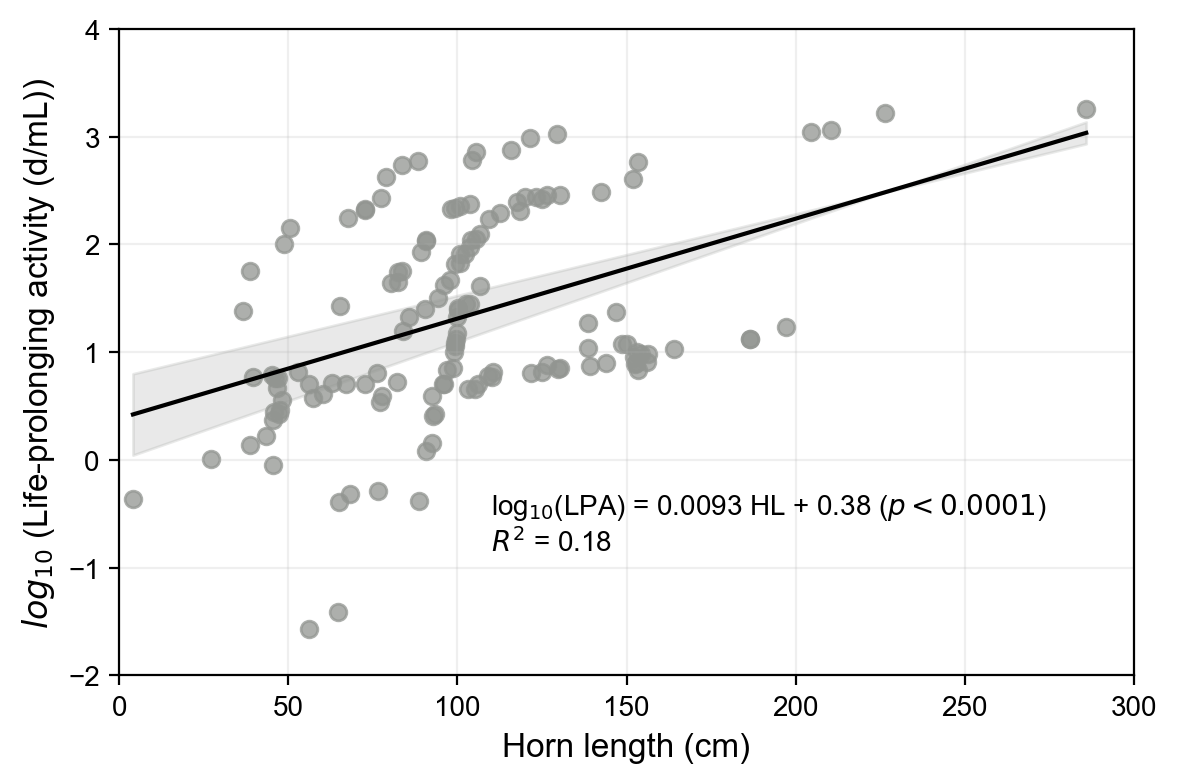

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

ax.scatter(x=hlba["Horn Length (cm)"], y=hlba["log10 Blood Activity (d/mL)"], color="xkcd:grey", alpha=0.75)

# Add the line plot over the point
domain = np.linspace(start = hlba["Horn Length (cm)"].min(), stop = hlba["Horn Length (cm)"].max(), num=100)
# line of best fit
ax.plot(domain, (model.params["Horn Length (cm)"]*domain) + model.params["const"], color="black")
# variance in parameters
ax.fill_between(domain, 
                ((model.params["Horn Length (cm)"]+ model.bse["Horn Length (cm)"])*domain) + model.params["const"] - model.params["const"],
                ((model.params["Horn Length (cm)"]- model.bse["Horn Length (cm)"])*domain) + model.params["const"] + model.params["const"],
                color="xkcd:grey", alpha=0.2)

ax.grid(alpha=0.2, which='major')

ax.set_yticks(np.arange(-2,5,1))

ax.set_xlim(0,300)
ax.set_ylim(-2,4)

# Add OLS details
ax.text(s=r"log$_{{10}}$(LPA) = {:0.2} HL + {:0.2} ($p<0.0001$)".format(model.params["Horn Length (cm)"], model.params["const"]), x=110, y=-0.5)
ax.text(s="$R^{{2}}$ = {:0.2}".format(model.rsquared), x=110, y=-0.85)

ax.set_xlabel("Horn length (cm)", size=12)
ax.set_ylabel("$log_{10}$ (Life-prolonging activity (d/mL))", size=12)

plt.tight_layout()

The above plot uses a couple features that I find very useful in matplotlib that I think deserve a little shoutout.

1. Using LaTex and pretty print allows you create nice mathematical formulae that automatically populate with values that might change (saving you the trouble of have to rewrite, round, and format numbers that may change as you alter the analysis).
2. `plt.fill_between` is a quick way of doing the work of multiple `plt.plot` functions, and is especially useful for showing confidence intervals.

#### Adding some color
Color is great. I have lots of colors and color combinations that I think look fun, but I have to remind myself that this is not entirely an art project, and colors should be used only to illustrate something necessary about the data. Color choices should be made carefully. In addition to the colormap guidelines from Matplotlib, above, here a few other things to consider:
- Human vary widely in their ability to differentiate color
- Avoid red/green palettes
- When plotting groups, use colors that are equally spaced around the color wheel
- Changing marker shapes or adding/changing bar patterns can be good alternatives to color

Let's replot the data, but color the points by their population. A really easy (and underutilized!) way of building legends in matplotlib is to us the `label` parameter when plotting.

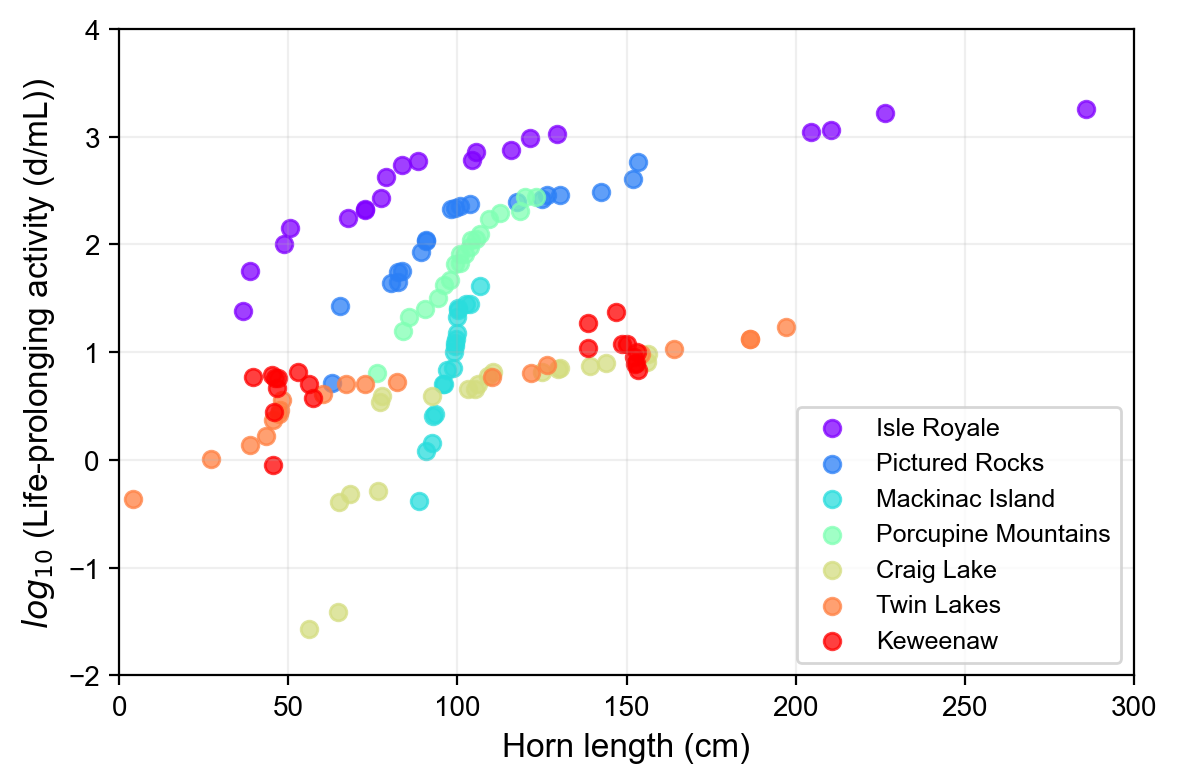

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

# Create a custom color range using the Spectral colormap 
cmap = plt.get_cmap('rainbow', len(uPops))
population_colors = {pop: cmap(i) for i, pop in enumerate(uPops)}

for pop in uPops:
    ax.scatter(x=hlba[hlba["Population"]==pop]["Horn Length (cm)"], y=hlba[hlba["Population"]==pop]["log10 Blood Activity (d/mL)"], 
               alpha=0.75, label=pop, color=population_colors[pop])

ax.grid(alpha=0.2, which='major')

ax.set_yticks(np.arange(-2,5,1))

ax.set_xlim(0,300)
ax.set_ylim(-2,4)

ax.set_xlabel("Horn length (cm)", size=12)
ax.set_ylabel("$log_{10}$ (Life-prolonging activity (d/mL))", size=12)

ax.legend(fontsize=9)

plt.tight_layout()

The above plot is a pretty good example of why rainbow color maps are usually bad choices. People like me, who have normal eyesight, struggle where these cyan-blue-green colors mix, despite the fact that they are evenly spaced. With seven populations, I would simply go ahead and pick seven colors I like, go well together, and _**most importantly**_ are distinct to most viewers (at some number of groups, it becomes impossible to avoid some colors entirely). I _love_ using the [xkcd named colors](https://xkcd.com/color/rgb/). Alternatively, matplotlib does a decent job with default colors when there are less than about 10 groups. Remember that picking colors is a task great for AI. For example, ask an AI to "make a function that randomly chooses N equally spaced colors for plotting in matplotlib".

In [31]:
def generate_random_colors(n, seed=None):
    """
    Written by Microsoft CoPilot.
    
    Generates n random colors from the entire color space.

    Parameters:
    n (int): Number of colors to generate.

    Returns:
    List of colors.
    """
    if seed: np.random.seed(seed)
    colors = []
    for _ in range(n):
        # Generate random RGB values
        color = (np.random.random(), np.random.random(), np.random.random())
        colors.append(color)
    return colors

In [32]:
aiColorMap = dict(zip(uPops, generate_random_colors(7, seed=9999)))
xkcdColorMap = dict(zip(uPops, ["xkcd:mauve", "xkcd:mango", "xkcd:denim blue", "xkcd:teal", "xkcd:cement", "xkcd:melon", "xkcd:periwinkle"]))
hlba["aiColor"] = hlba["Population"].map(aiColorMap)
hlba["xkcdColor"] = hlba["Population"].map(xkcdColorMap)

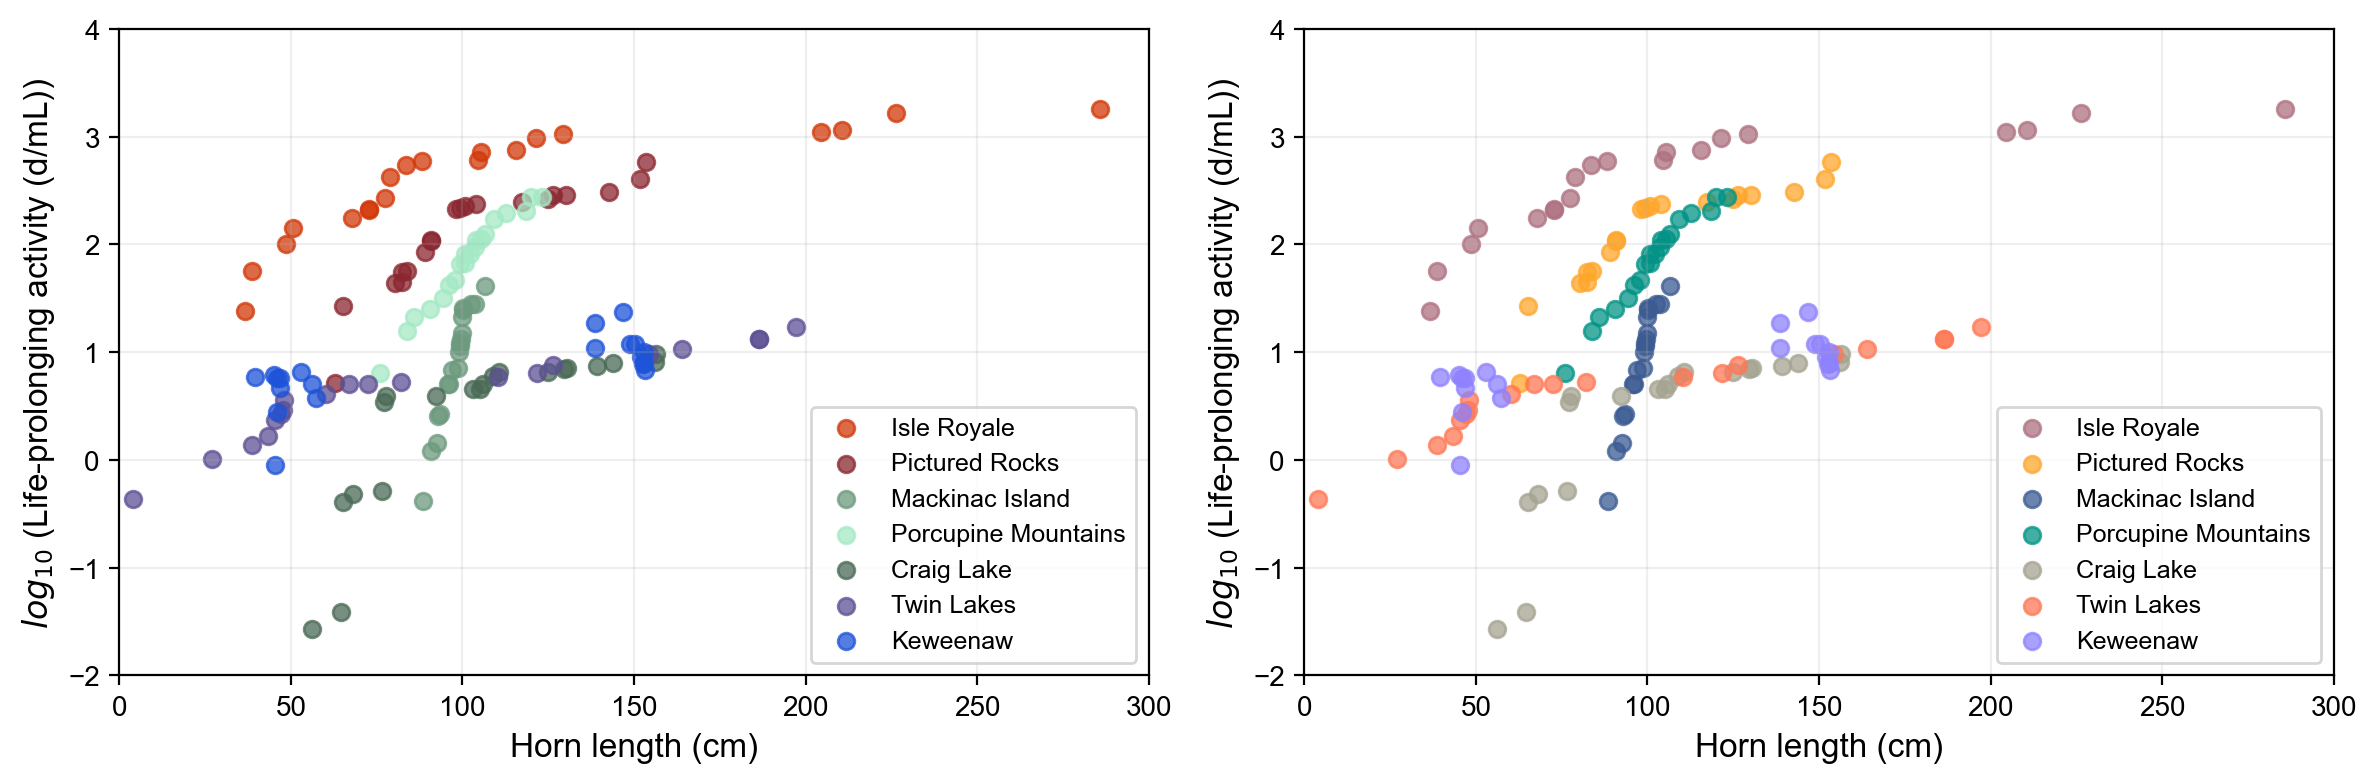

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for pop in uPops:
    ax[0].scatter(x=hlba[hlba["Population"]==pop]["Horn Length (cm)"], y=hlba[hlba["Population"]==pop]["log10 Blood Activity (d/mL)"], 
               alpha=0.75, label=pop, color=aiColorMap[pop])
    ax[1].scatter(x=hlba[hlba["Population"]==pop]["Horn Length (cm)"], y=hlba[hlba["Population"]==pop]["log10 Blood Activity (d/mL)"], 
               alpha=0.75, label=pop, color=xkcdColorMap[pop])

for i in [0,1]:
    ax[i].grid(alpha=0.2, which='major')
    ax[i].set_yticks(np.arange(-2,5,1))
    ax[i].set_xlim(0,300)
    ax[i].set_ylim(-2,4)
    ax[i].set_xlabel("Horn length (cm)", size=12)
    ax[i].set_ylabel("$log_{10}$ (Life-prolonging activity (d/mL))", size=12)
    ax[i].legend(fontsize=9)
    
plt.tight_layout()

Not all random colormaps will be winners (see above), but you can set a random seed to reproduce ones you like by using `np.random.seed`.

When we apply our colormap, it becomes apparent that some populations may differ in the strength of the horn length-blood activity relationship.

What should I do if I want to show even more high dimensional data?

My initial reply would be another question: Do you _**really**_ need to jam all those dimensions into 2D space? Unless you _really, really_ need to, I'd suggest you think about how to most intuitively display the multiple factors.

Let's say you've got one of those _really, really_ scenarios. This gives us another opportunity to work with legends and also to get into the world of markers.

In [34]:
def poisson_resample(lam, size, n):
    '''A Poisson sampler that resamples any observations greater than n'''
    samples = np.random.poisson(lam, size)
    while np.any(samples > n):
        samples[samples > n] = np.random.poisson(lam, np.sum(samples > n))
    return samples

In [35]:
ageClassDict = {0:"foal", 1:"yearling", 2:"adolescent", 3:"adult", 4:"senior"}
ageClass = poisson_resample(lam=3, size=len(hlba), n=4)

ageClass = []
for i in range(len(uPops)):
    ageClass.append(sorted(poisson_resample(lam=3, size=20, n=4)))
ageClass = flatten(ageClass)
hlba["Age Class"] = ageClass
hlba["Age Class"] = hlba["Age Class"].map(ageClassDict)

ageClassMarkerDict = {"foal":"o", "yearling":"^", "adolescent":"d", "adult":"x", "senior":"s"}
hlba["Age Class Marker"] = hlba["Age Class"].map(ageClassMarkerDict)

hlba.head()

Population  Horn Length (cm)  log10 Blood Activity (d/mL)  Individual  \
0  Isle Royale         36.552388                     1.382032           1   
1  Isle Royale         38.745385                     1.750049           2   
2  Isle Royale         48.619956                     2.001070           3   
3  Isle Royale         50.529259                     2.153432           4   
4  Isle Royale         67.702317                     2.247249           5   

                                             aiColor   xkcdColor Age Class  \
0  (0.8233890742543671, 0.21860274485134001, 0.03...  xkcd:mauve      foal   
1  (0.8233890742543671, 0.21860274485134001, 0.03...  xkcd:mauve      foal   
2  (0.8233890742543671, 0.21860274485134001, 0.03...  xkcd:mauve  yearling   
3  (0.8233890742543671, 0.21860274485134001, 0.03...  xkcd:mauve  yearling   
4  (0.8233890742543671, 0.21860274485134001, 0.03...  xkcd:mauve  yearling   

  Age Class Marker  
0                o  
1                o  
2                ^  
3                ^  
4                ^

This is a little annoying because, unlike other parameters like `color`, we cannot pass an array to `marker`.

/var/folders/6y/1tfk97jj5pz9h97s08kn33zm0000gn/T/ipykernel_23458/3147734636.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


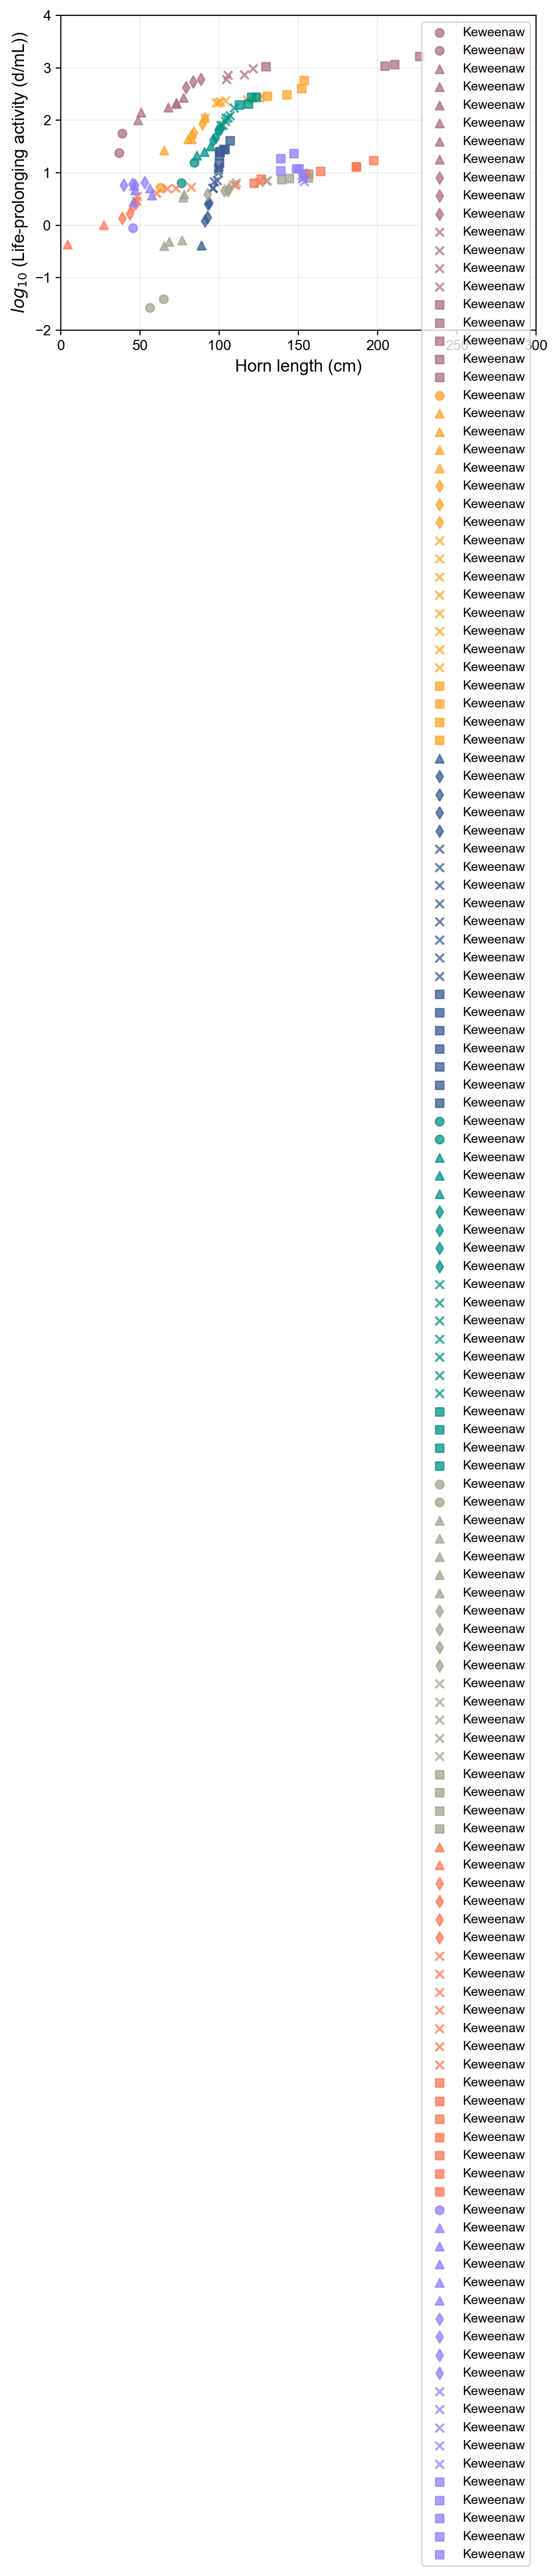

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for i,row in hlba.iterrows():
    ax.scatter(x=row["Horn Length (cm)"], 
               y=row["log10 Blood Activity (d/mL)"], 
               marker=row["Age Class Marker"], alpha=0.75, label=pop, color=row['xkcdColor'])


ax.grid(alpha=0.2, which='major')
ax.set_yticks(np.arange(-2,5,1))
ax.set_xlim(0,300)
ax.set_ylim(-2,4)
ax.set_xlabel("Horn length (cm)", size=12)
ax.set_ylabel("$log_{10}$ (Life-prolonging activity (d/mL))", size=12)
ax.legend(fontsize=9)
    
plt.tight_layout()

Yikes! That's not a good use of the `label` parameter. You want to plot more complex data? You need to make custom legends (don't worry, it isn't that scary, especially since AI can help). For this, I'm going to introduce one of my favorite new(ish) matplotlib innovations: [`subplot_mosaic`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot_mosaic.html).

`subplot_mosaic` takes all the best parts of subplot and gridspec formatting and throws aways all (okay, most) of the complicated organizing and referencing by allowing the user to specific a mosaic pattern of their plots with easy to reference names. This is done by passing a multiline string to the `mosaic` parameter. Inside that string, each letter refers to a subplot and empty areas can be specified with `.`s. For example, a four by four grid with the diagonal plots missing would be 

```
'''.BCD
   E.FG
   HI.K
   LMN.'''
```

The letters themselves aren't important; that is, you could swap `B` with `X`, and all that would change is that you refer to that subplot as `ax['X']` instead of `ax['B']`. The handy `width_ratios` and `height_ratios` also work, or you can still get maximally crazy and use `gridspec` to altern them individually.

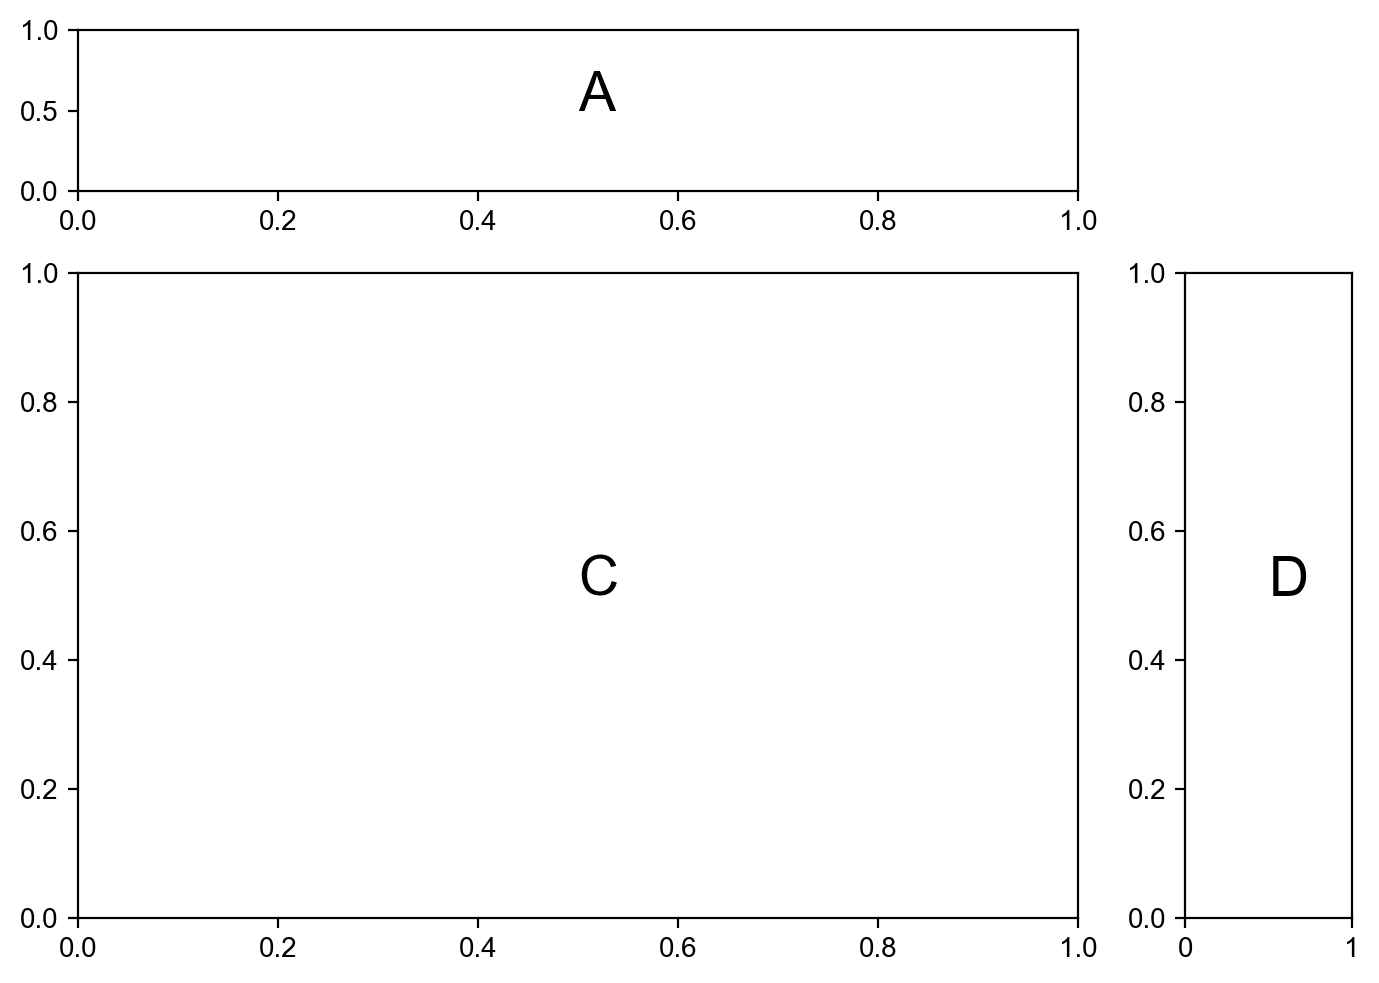

In [37]:
fig, ax = plt.subplot_mosaic(mosaic = """A.
                                         CD""", figsize=(7,5), width_ratios=[6,1], height_ratios=[1,4])

ax['A'].text(x=0.5, y=0.5, s="A", size=20)
ax['C'].text(x=0.5, y=0.5, s="C", size=20)
ax['D'].text(x=0.5, y=0.5, s="D", size=20)

plt.tight_layout()

Instead of using height and width ratios, you can instead draw out the subplot areas.

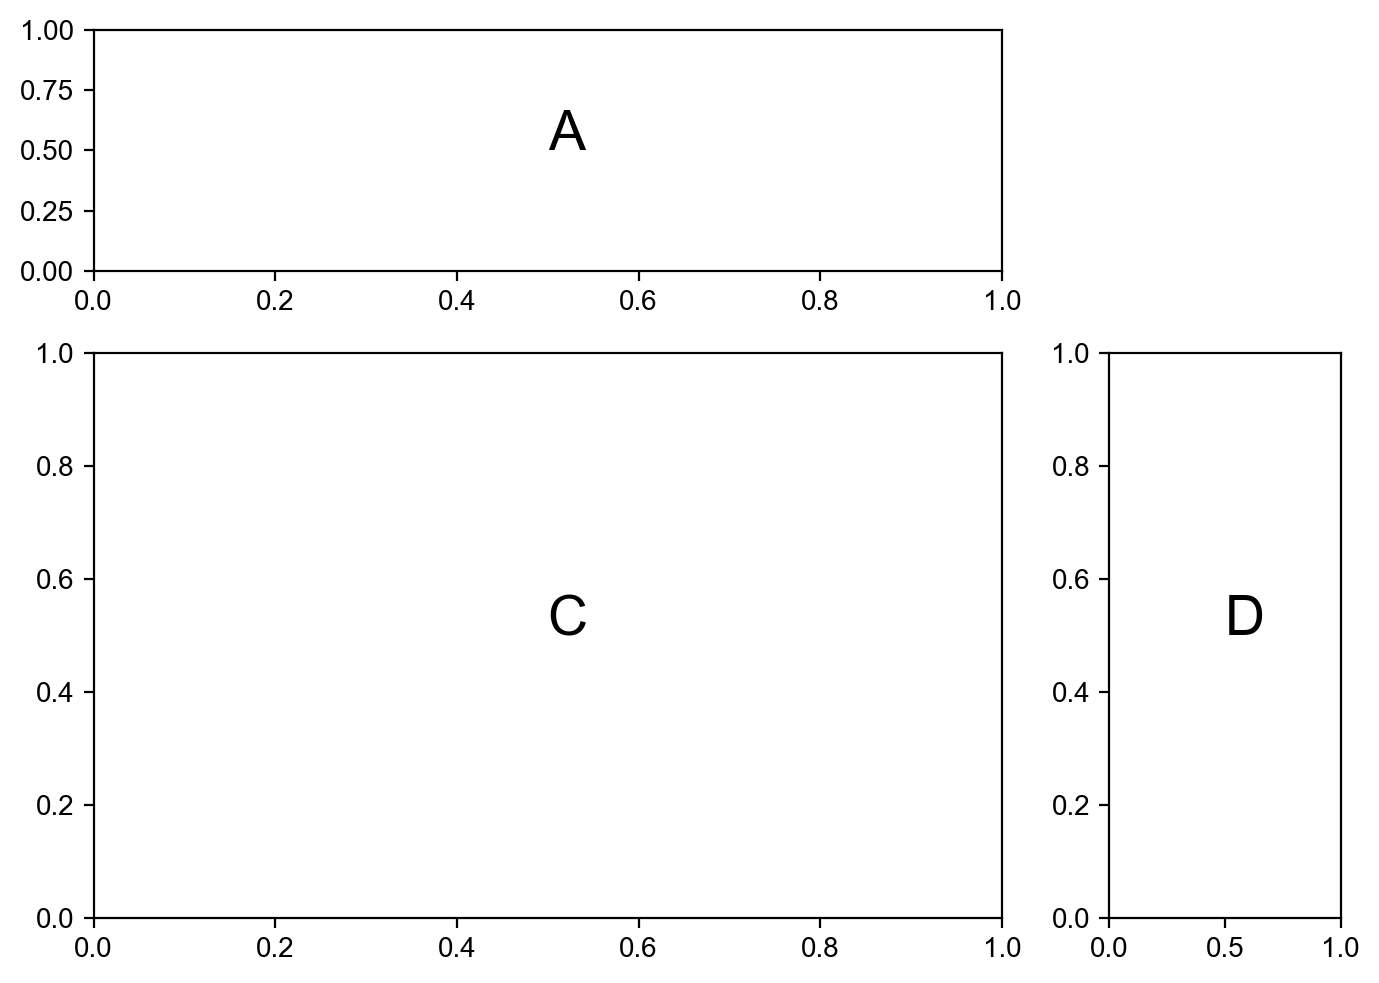

In [38]:
fig, ax = plt.subplot_mosaic(mosaic = """AAA.
                                         CCCD
                                         CCCD""", figsize=(7,5))

ax['A'].text(x=0.5, y=0.5, s="A", size=20)
ax['C'].text(x=0.5, y=0.5, s="C", size=20)
ax['D'].text(x=0.5, y=0.5, s="D", size=20)

plt.tight_layout()

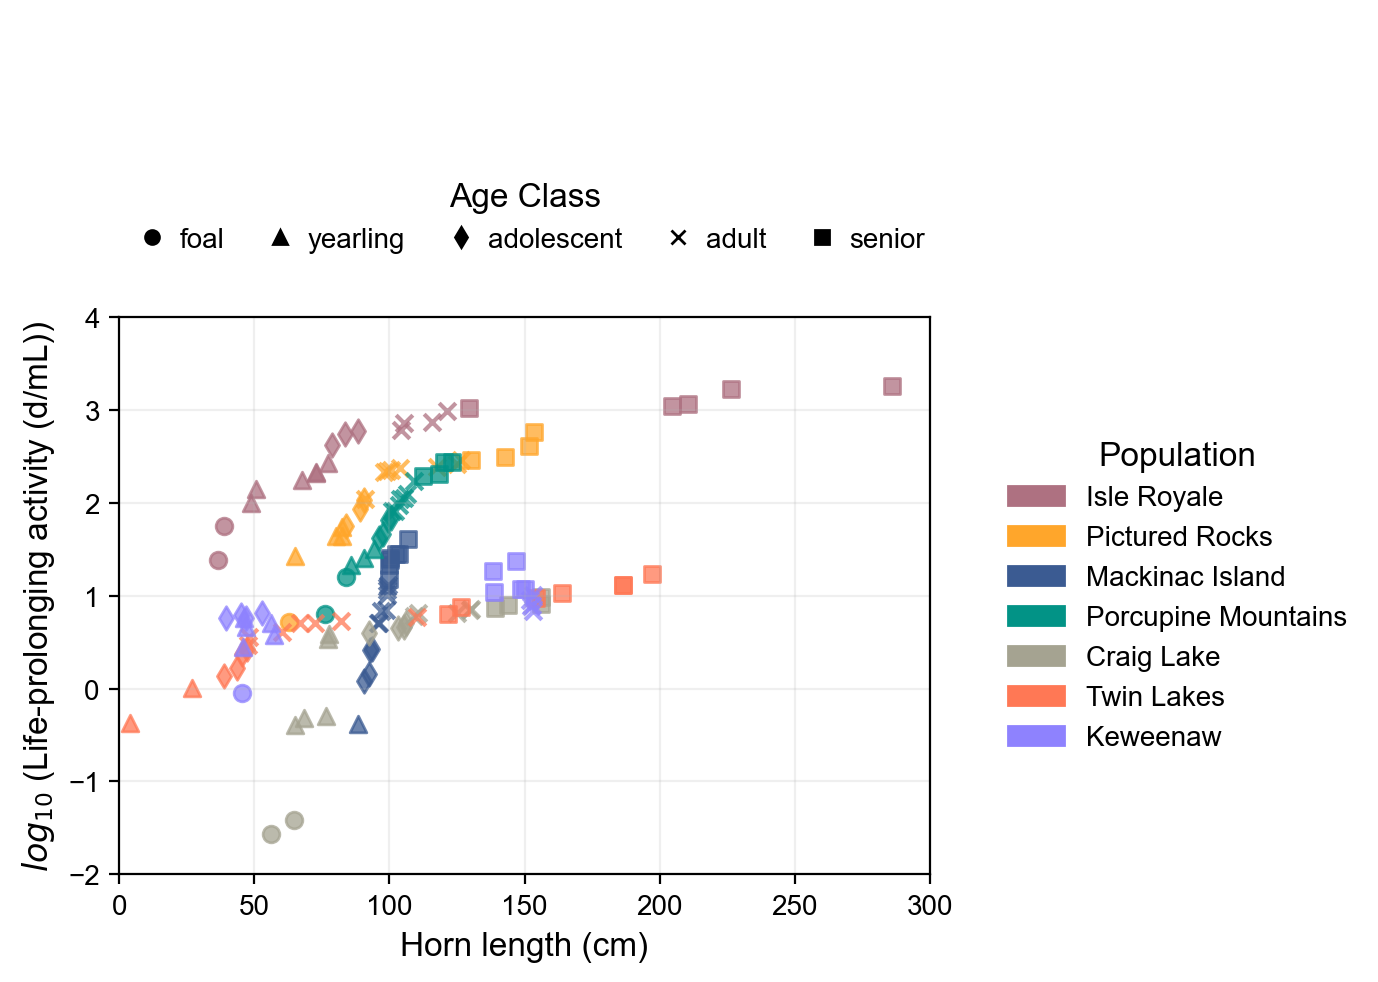

In [39]:
fig, ax = plt.subplot_mosaic(mosaic = """AAA.
                                         CCCD
                                         CCCD""", figsize=(7,5))

for i,row in hlba.iterrows():
    ax["C"].scatter(x=row["Horn Length (cm)"], 
               y=row["log10 Blood Activity (d/mL)"], 
               marker=row["Age Class Marker"], alpha=0.75, color=row['xkcdColor'])

ax["C"].grid(alpha=0.2, which='major')
ax["C"].set_yticks(np.arange(-2,5,1))
ax["C"].set_xlim(0,300)
ax["C"].set_ylim(-2,4)
ax["C"].set_xlabel("Horn length (cm)", size=12)
ax["C"].set_ylabel("$log_{10}$ (Life-prolonging activity (d/mL))", size=12)

for l in 'AD':
    ax[l].spines[['right','left','top','bottom']].set_visible(False)
    ax[l].set_xticks([])
    ax[l].set_yticks([])

# Create custom age class legend
ageLegElems = []
for k,v in ageClassMarkerDict.items():
    ageLegElems.append(mlines.Line2D([0], [0], marker=v, color='black', label=k, markerfacecolor='black', markersize=5, linestyle=''))

ax['A'].legend(handles=ageLegElems, ncols=5, frameon=False, loc="lower center",
               columnspacing=1, handletextpad=0, title="Age Class", title_fontsize=12)

# Create custom population legend
popPatches = []
for k,v in xkcdColorMap.items():
    popPatches.append(mpatches.Patch(color=v, label=k))

ax['D'].legend(handles=popPatches, ncols=1, frameon=False, title="Population", title_fontsize=12,  loc="center left")
    
plt.tight_layout()

While were working on plotting multiple data sets together, let's touch on a common plotting mistake that I find beyond simply negligent: _**nefarious plot reordering**_.

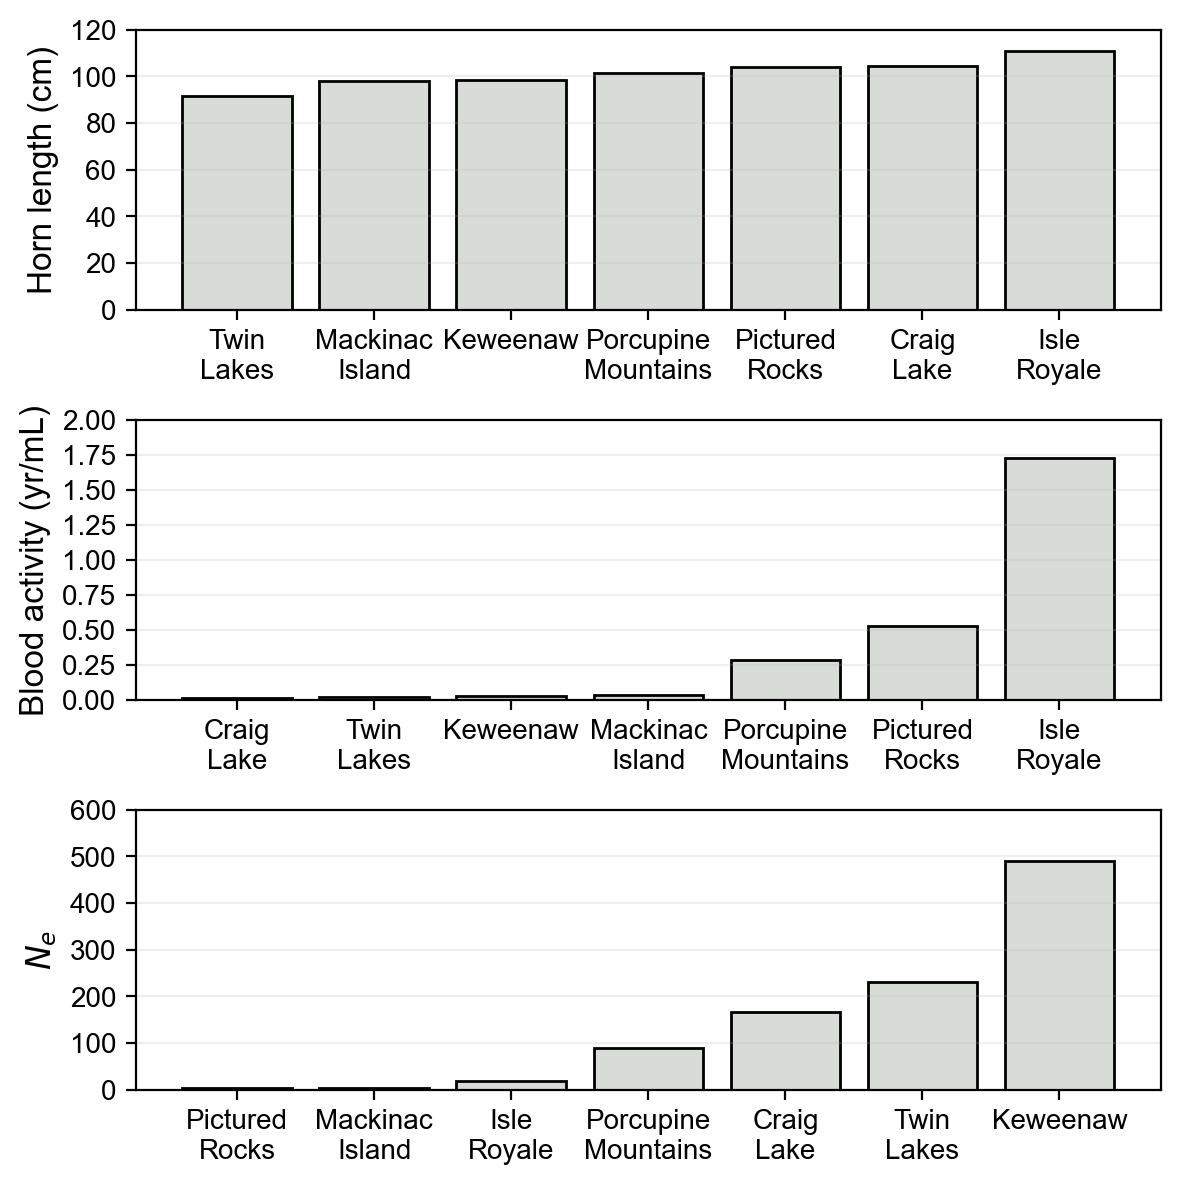

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

foo = hornLen.reindex(hornLen.mean().sort_values().index, axis=1)
ax[0].bar(x=range(len(foo.columns)), height=foo.mean(axis=0), color="xkcd:light grey", edgecolor="xkcd:black")

bar = bloodActivity.reindex(bloodActivity.mean().sort_values().index, axis=1)
ax[1].bar(x=range(len(bar.columns)), height=bar.mean(axis=0), color="xkcd:light grey", edgecolor="xkcd:black")

bim = popSize.reindex(popSize.mean().sort_values().index, axis=1)
ax[2].bar(x=range(len(bim.columns)), height=bim.mean(axis=0), color="xkcd:light grey", edgecolor="xkcd:black")

for i in range(3):
    ax[i].set_xticks(np.arange(0,7,1))
    ax[i].grid(alpha=0.2, axis='y')

ax[0].set_xticklabels(foo.columns.str.replace(" ","\n"))
ax[1].set_xticklabels(bar.columns.str.replace(" ","\n"))
ax[2].set_xticklabels(bim.columns.str.replace(" ","\n"))

ax[0].set_yticks(np.arange(0,140,20))
ax[1].set_yticks(np.arange(0,2.25,0.25))
ax[2].set_yticks(np.arange(0,700,100))

ax[0].set_ylim(0,120)
ax[1].set_ylim(0,2.0)
ax[2].set_ylim(0, 600)

ax[0].set_ylabel("Horn length (cm)", size=12)
ax[1].set_ylabel("Blood activity (yr/mL)", size=12)
ax[2].set_ylabel("$N_{e}$", size=12)

plt.tight_layout()

The choice to reorder by increasing or decreasing values gives the cursory reader the impression that these features are correlated. This is incredibly misleading!

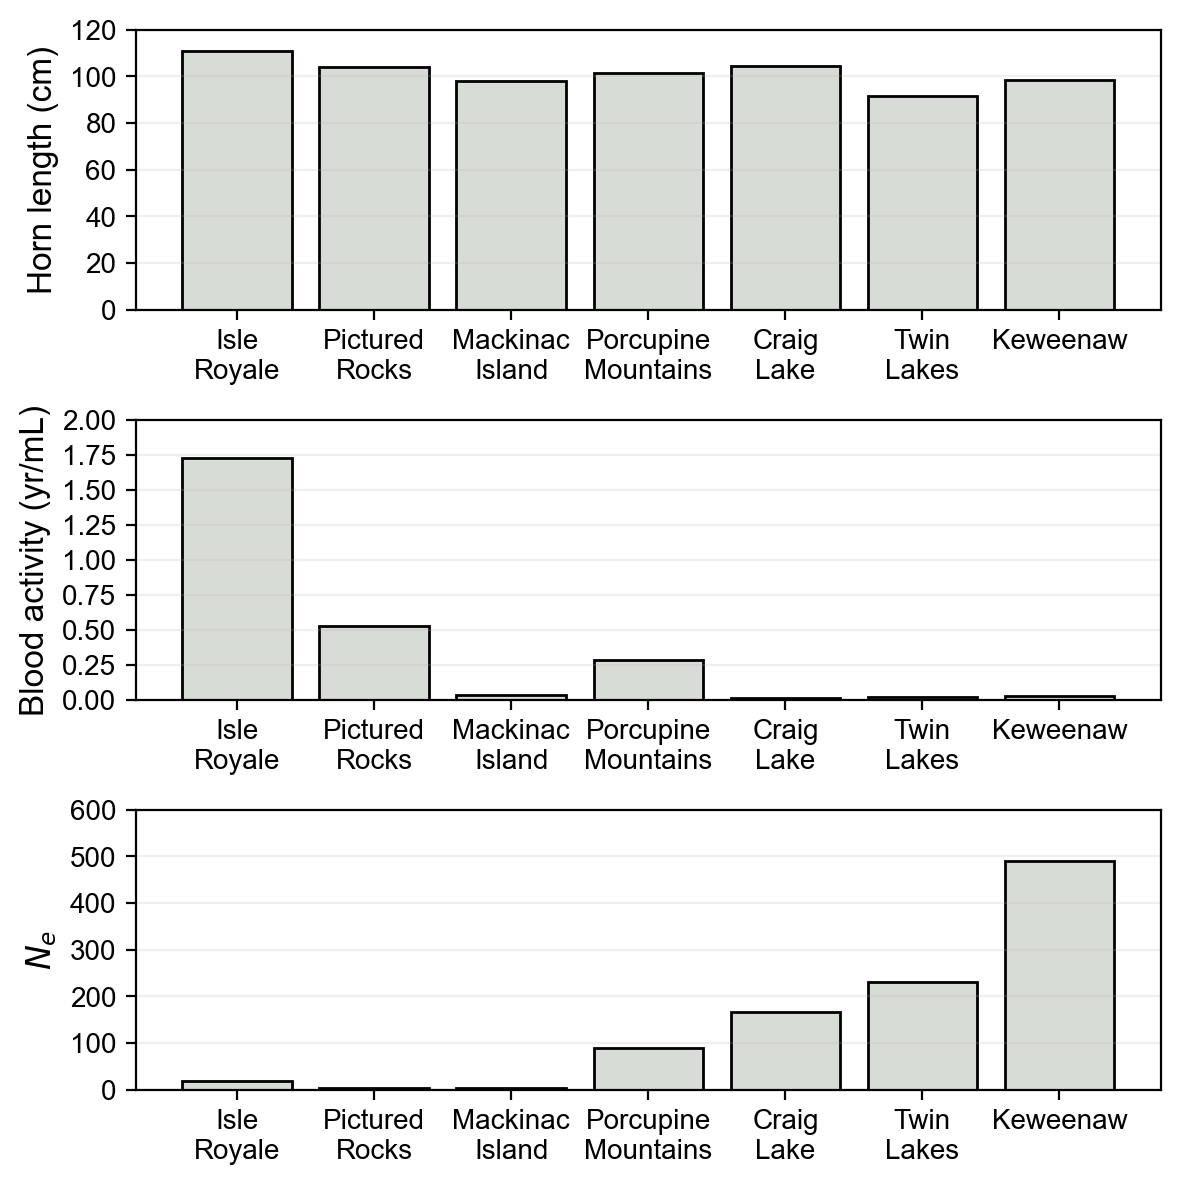

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

ax[0].bar(x=range(len(hornLen.columns)), height=hornLen.mean(axis=0), color="xkcd:light grey", edgecolor="xkcd:black")
ax[1].bar(x=range(len(bloodActivity.columns)), height=bloodActivity.mean(axis=0), color="xkcd:light grey", edgecolor="xkcd:black")
ax[2].bar(x=range(len(popSize.columns)), height=popSize.mean(axis=0), color="xkcd:light grey", edgecolor="xkcd:black")

for i in range(3):
    ax[i].set_xticks(np.arange(0,7,1))
    ax[i].grid(alpha=0.2, axis='y')

ax[0].set_xticklabels(hornLen.columns.str.replace(" ","\n"))
ax[1].set_xticklabels(bloodActivity.columns.str.replace(" ","\n"))
ax[2].set_xticklabels(popSize.columns.str.replace(" ","\n"))

ax[0].set_yticks(np.arange(0,140,20))
ax[1].set_yticks(np.arange(0,2.25,0.25))
ax[2].set_yticks(np.arange(0,700,100))

ax[0].set_ylim(0,120)
ax[1].set_ylim(0,2.0)
ax[2].set_ylim(0, 600)

ax[0].set_ylabel("Horn length (cm)", size=12)
ax[1].set_ylabel("Blood activity (yr/mL)", size=12)
ax[2].set_ylabel("$N_{e}$", size=12)

plt.tight_layout()

#### Take aways
- Think hard about scale and avoid mixing scales (e.g., linear and logarithmic)
- Colors are pretty but should be used carefully
    - Use distinct colors
- Generally avoid rearraning data, humans love seeing patterns where they don't exist!
- Take advantage of tools like `tight_layout`, `subplot_mosaic`, and others to create ready to publish, multi-panel figures
- Spend some time finessing your colors, colorbars and legends, and don't forget that you can use LaTex and text formatting to provide necessary information to plots.

## 3. RNAseq-like data
Plotting RNAseq data is a great way of combining many of the above skills into single, complex figures with multiple subplots. I'll also use some space to graphing heatmaps.

First I'll generate some gene expression data collected throughout a day for 40 genes -- thanks CoPilot!

In [42]:
# Set random seed for reproducibility
np.random.seed(42)

# Create time points (6 time points every 4 hours)
time_points = [2,6,10,14,18,22]

# Create 40 genes and divide them into 4 expression patterns
genes = [f"Gene{i+1}" for i in range(40)]
patterns = {
    'Pattern_1': np.sin(np.linspace(0, 2 * np.pi, len(time_points))),  # Sinusoidal
    'Pattern_2': np.cos(np.linspace(0, 2 * np.pi, len(time_points))),  # Cosine
    'Pattern_3': np.linspace(1, 0, len(time_points)),                 # Linear decrease
    'Pattern_4': np.linspace(0, 1, len(time_points))                  # Linear increase
}

# Generate the dataset
data = []
for i, gene in enumerate(genes):
    pattern = patterns[f'Pattern_{(i % 4) + 1}']
    expression = pattern + np.random.normal(2, 0.1, len(time_points))  # Add some noise
    scale = np.random.normal()
    data.append(expression * (10**scale))

# Create a DataFrame
exp = pd.DataFrame(data, index=genes, columns=time_points)
exp.head()

2           6           10         14         18         22
Gene1  77.785216  111.468147  100.664668  59.373590  38.918886  75.011629
Gene2   0.037567    0.027620    0.015205   0.013976   0.027625   0.036926
Gene3  82.613809   80.167192   73.007222  71.041087  61.626292  54.309316
Gene4   4.696750    5.241453    5.362047   6.046188   6.676873   6.852182
Gene5  12.892358   19.418172   16.797930  10.616226   6.962061  12.588598

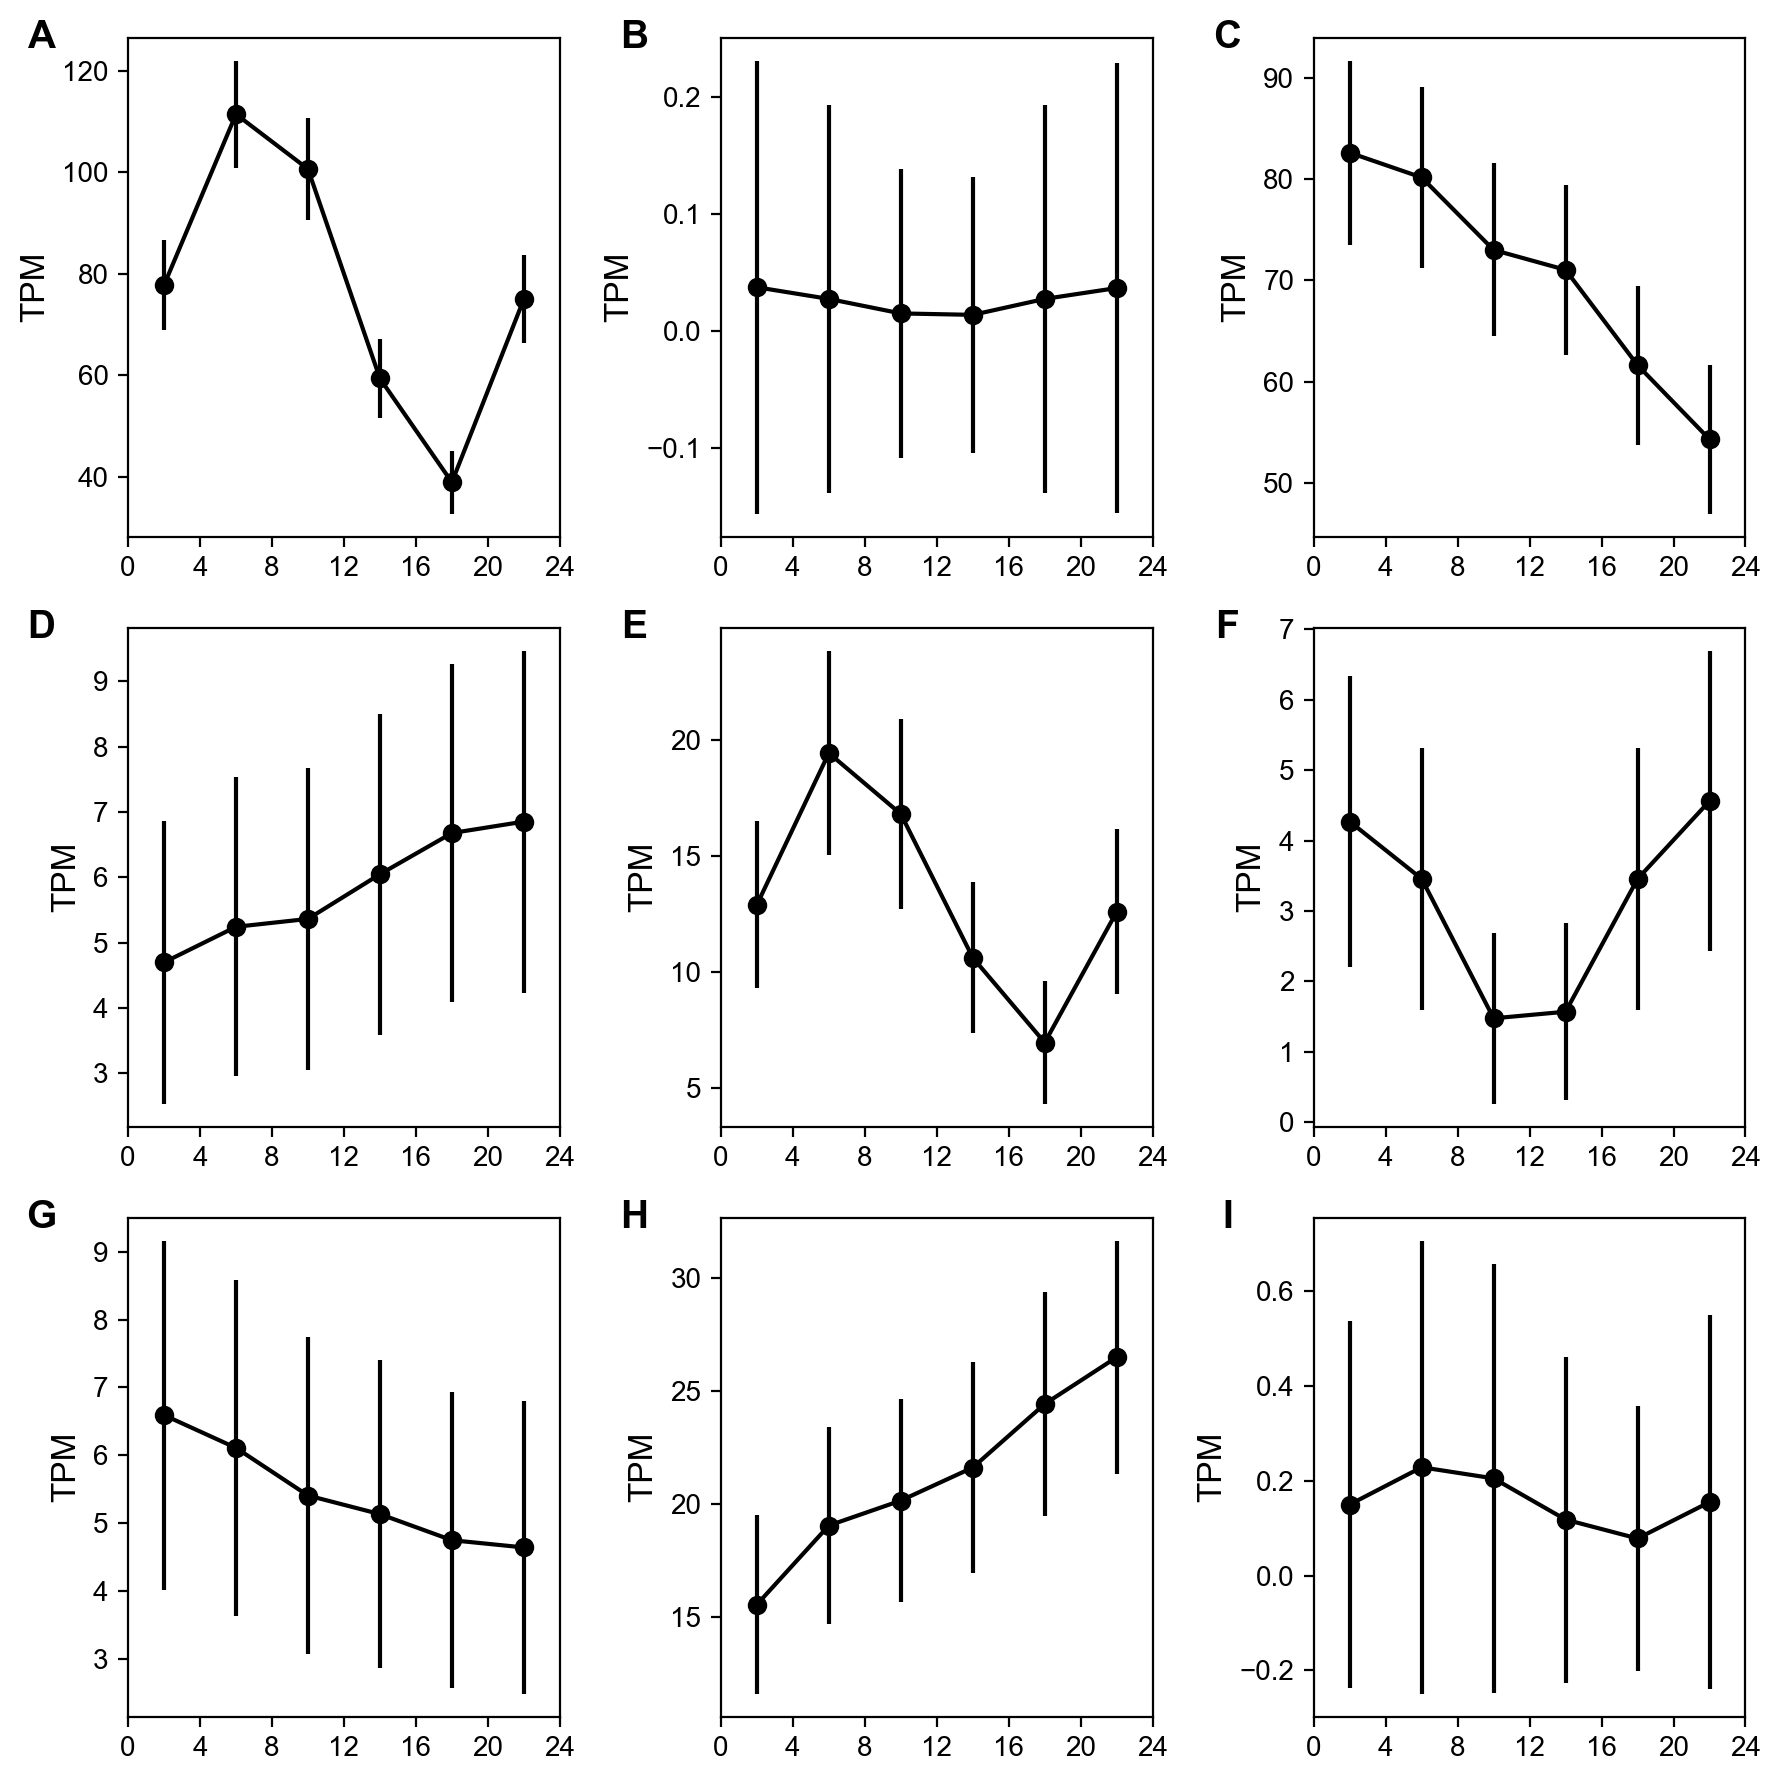

In [43]:
fig, ax = plt.subplot_mosaic('''ABC
                                DEF
                                GHI''', figsize=(9,9))
for i in range(9):
    l = string.ascii_uppercase[i]
    
    ax[l].errorbar(x=exp.columns, y=exp.loc["Gene{}".format(i+1)], yerr=np.sqrt(np.abs(exp.loc["Gene{}".format(i+1)])), 
                   marker="o", color="black")

    ax[l].set_xticks(np.arange(0,28,4))
    ax[l].set_xlim(0,24)
    ax[l].set_ylabel("TPM", size=12)
    ax[l].text(-0.2, 1, l, transform=ax[l].transAxes, weight="bold", fontsize=14, ha='center', va='center')
    
plt.tight_layout()

A decent start, but I'm particularly interested in circadian related genes in the unicorn, so I'd like to indicate daytime and nighttime on my plot.

This can be done using patches, and easily automated by using the axes proporties to create patches of appropriate size for each plot.

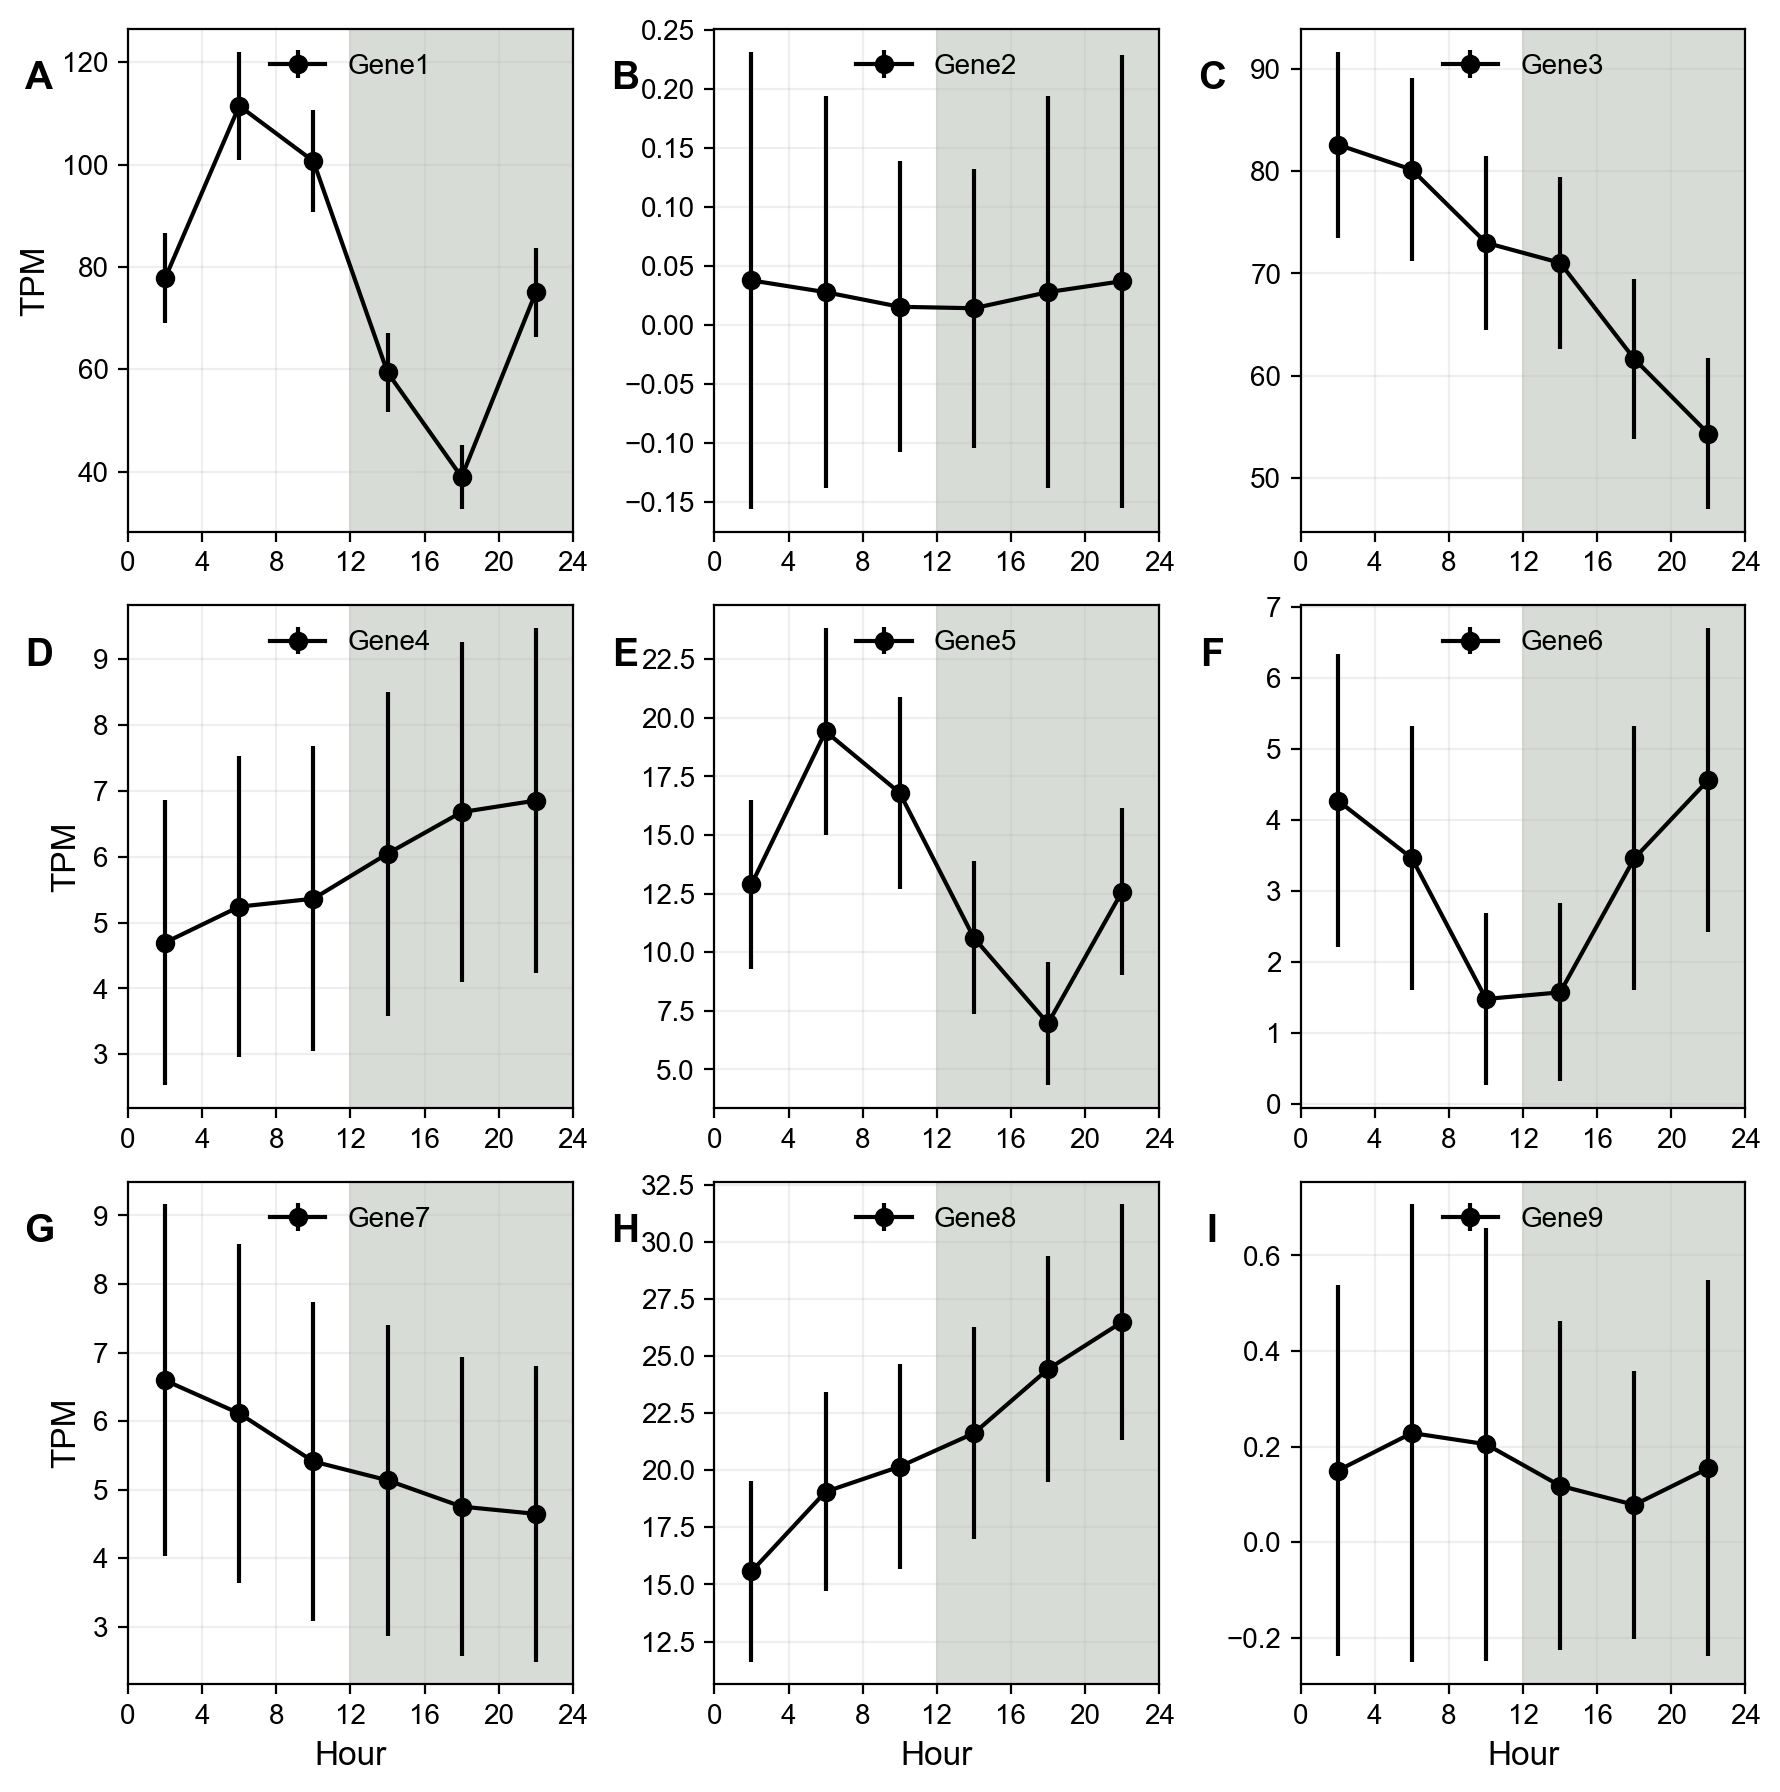

In [44]:
fig, ax = plt.subplot_mosaic('''ABC
                                DEF
                                GHI''', figsize=(9,9))
for i in range(9):
    l = string.ascii_uppercase[i]
    
    ax[l].errorbar(x=exp.columns, y=exp.loc["Gene{}".format(i+1)], yerr=np.sqrt(np.abs(exp.loc["Gene{}".format(i+1)])), 
                   marker="o", color="black", label="Gene{}".format(i+1))  
    ax[l].legend(frameon=False, loc='upper center')
    
    ax[l].set_xticks(np.arange(0,28,4))
    ax[l].set_xlim(0,24)

    if l in 'ADG': ax[l].set_ylabel("TPM", size=12)
    if l in 'GHI': ax[l].set_xlabel("Hour", size=12)
        
    ax[l].text(-0.2, 0.9, l, transform=ax[l].transAxes, weight="bold", fontsize=14, ha='center', va='center')

    nightPatch = mpatches.Rectangle(xy=(12,ax[l].get_ylim()[0]), width=12, height=ax[l].get_ylim()[1]-ax[l].get_ylim()[0], color="xkcd:light gray") 
    ax[l].add_patch(nightPatch)  

    ax[l].grid(alpha=0.2)

plt.tight_layout()

While that's an improvement, I think it can be a little misleading the combine so many different scales. A common way of dealing with this is to normalize the data so that the patterns are highlighted, rather than the magnitude.

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
expScaled = pd.DataFrame(scaler.fit_transform(exp.T).T, columns=exp.columns, index=exp.index)
expScaled.head()

2         6         10        14        18        22
Gene1  0.024032  1.416005  0.969543 -0.736843 -1.582149 -0.090589
Gene2  1.192423  0.121995 -1.214053 -1.346231  0.122487  1.123379
Gene3  1.228003  0.980784  0.257302  0.058633 -0.892688 -1.632035
Gene4 -1.429343 -0.731597 -0.577120  0.299241  1.107127  1.331692
Gene5 -0.079364  1.538114  0.888665 -0.643523 -1.549239 -0.154654

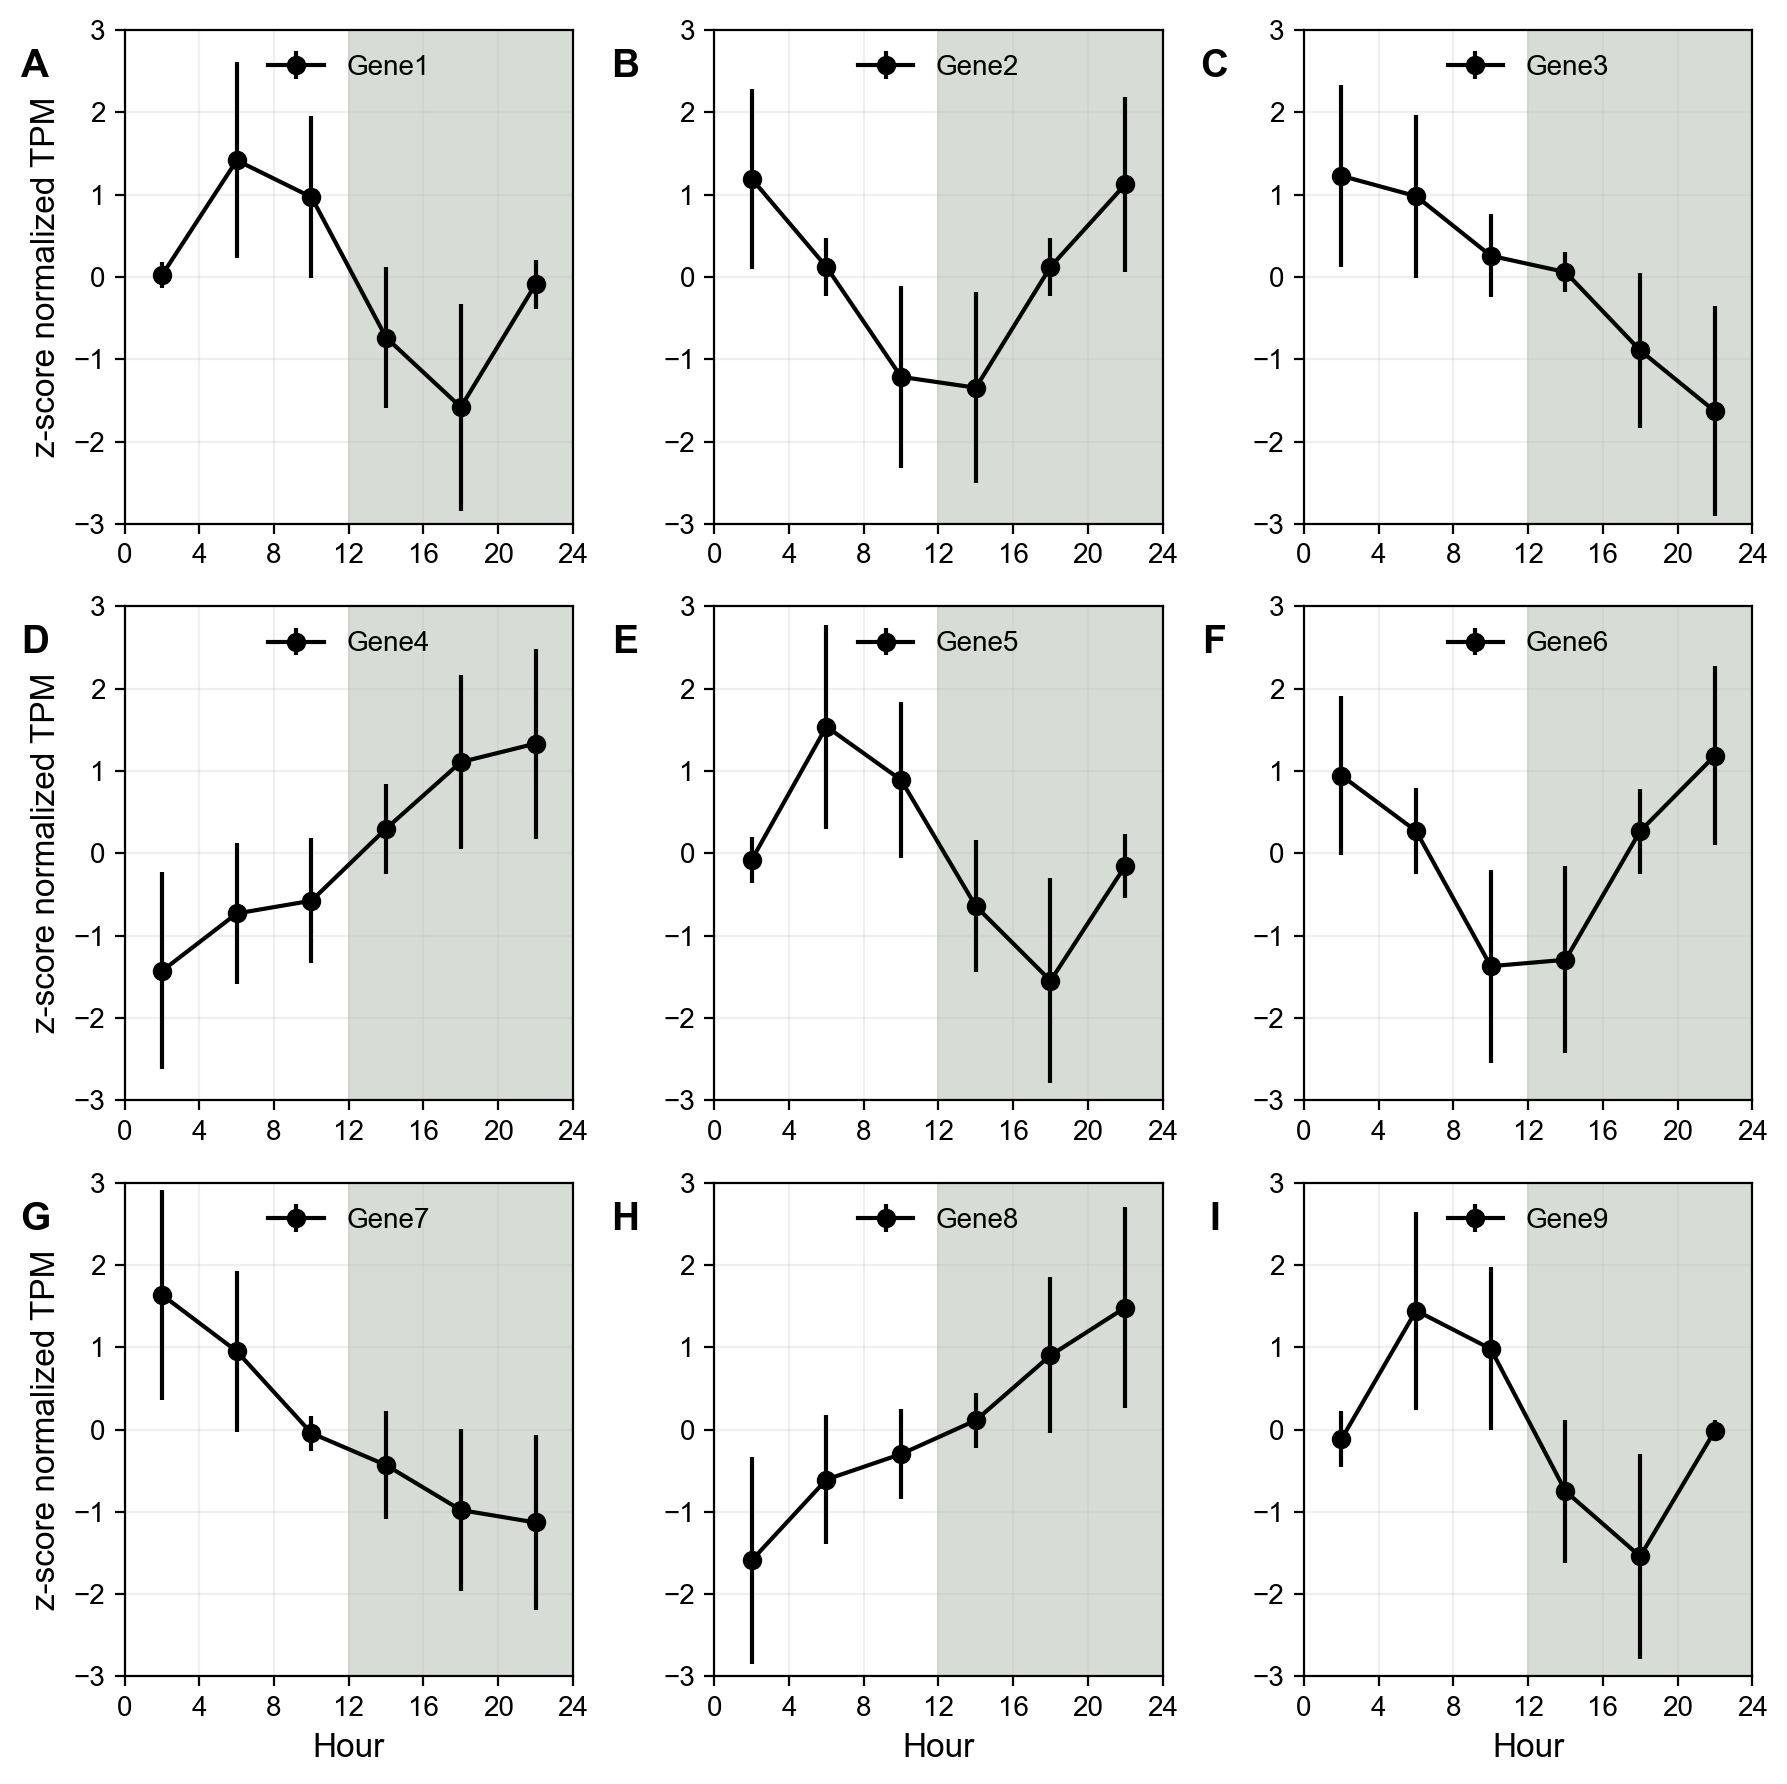

In [46]:
fig, ax = plt.subplot_mosaic('''ABC
                                DEF
                                GHI''', figsize=(9,9))
for i in range(9):
    l = string.ascii_uppercase[i]
    
    ax[l].errorbar(x=expScaled.columns, y=expScaled.loc["Gene{}".format(i+1)], yerr=np.sqrt(np.abs(expScaled.loc["Gene{}".format(i+1)])), 
                   marker="o", color="black", label="Gene{}".format(i+1))  
    ax[l].legend(frameon=False, loc='upper center')
    
    ax[l].set_xticks(np.arange(0,28,4))
    ax[l].set_xlim(0,24)
    ax[l].set_ylim(-3,3)

    if l in 'ADG': ax[l].set_ylabel("z-score normalized TPM", size=12)
    if l in 'GHI': ax[l].set_xlabel("Hour", size=12)
        
    ax[l].text(-0.2, 0.925, l, transform=ax[l].transAxes, weight="bold", fontsize=14, ha='center', va='center')

    nightPatch = mpatches.Rectangle(xy=(12,ax[l].get_ylim()[0]), width=12, height=ax[l].get_ylim()[1]-ax[l].get_ylim()[0], color="xkcd:light gray") 
    ax[l].add_patch(nightPatch)  

    ax[l].grid(alpha=0.2)

plt.tight_layout()

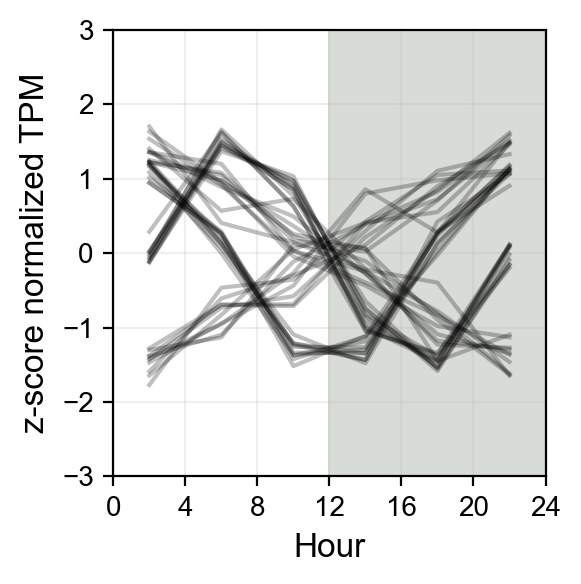

In [47]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3,3))

for i, ind in enumerate(expScaled.index):
    ax.plot(expScaled.columns, expScaled.loc[ind], color="black", alpha=0.25)  

ax.set_xticks(np.arange(0,28,4))
ax.set_xlim(0,24)
ax.set_ylim(-3,3)

nightPatch = mpatches.Rectangle(xy=(12,ax.get_ylim()[0]), width=12, height=ax.get_ylim()[1]-ax.get_ylim()[0], color="xkcd:light gray") 
ax.add_patch(nightPatch)  

ax.grid(alpha=0.2)

ax.set_ylabel("z-score normalized TPM", size=12)
ax.set_xlabel("Hour", size=12)

plt.tight_layout()

By normalizing and plotting together, it's apparent that there are four major patterns of gene expression.

A common next step is to visualize these patterns as a heat map, especially for real data sets where the patterns are harder to distinguish.

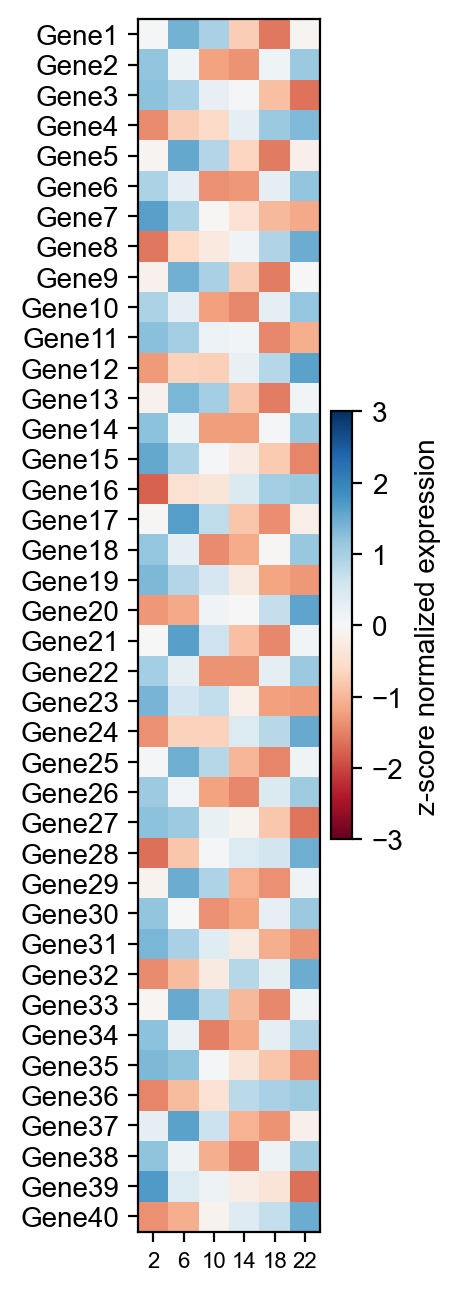

In [48]:
fig, ax = plt.subplots(figsize=(2,8))

cmapDict = {"sequential":"viridis", "cyclic":"hsv", "diverging":"RdBu"}

hmap = ax.imshow(expScaled, cmap=cmapDict["diverging"], vmin=-3, vmax=3)

cbar = plt.colorbar(hmap, ax=ax, aspect=20, fraction=0.1, orientation="vertical", location="right")
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("z-score normalized expression",size=10)

ax.set_xticks(np.arange(0,6,1))
ax.set_xticklabels(np.arange(2,26,4), size=8)
ax.set_xlim(-0.5,5.5)

ax.set_yticks(range(len(expScaled)))
ax.set_yticklabels(list(expScaled.index))

plt.tight_layout()

Well that didn't help. Looks like all the data are random!

Let's try clustering the data to see if we can find those patterns we know are in there.

In [49]:
from scipy.cluster.hierarchy import dendrogram, ward, set_link_color_palette
from sklearn import cluster

In [50]:
expWard = cluster.AgglomerativeClustering(n_clusters=4, linkage="ward")
clusters = expWard.fit_predict(expScaled)

# Generate linkage matrix
linkageMatrix = ward(expScaled)

# Add cluster labels to the DataFrame and sort by cluster
expSorted = expScaled.copy()
expSorted['Cluster'] = clusters
expSorted = expSorted.sort_values('Cluster')
expSorted

2         6        10        14        18        22  Cluster
Gene20 -1.300827 -1.131454  0.115676  0.022703  0.709475  1.584427        0
Gene36 -1.468739 -0.947746 -0.437382  0.800633  0.979810  1.073424        0
Gene32 -1.413370 -0.947975 -0.265812  0.858919  0.279140  1.489098        0
Gene28 -1.643825 -0.828680  0.048786  0.409476  0.552979  1.461263        0
Gene24 -1.375938 -0.691398 -0.685417  0.406856  0.825228  1.520669        0
Gene16 -1.770638 -0.463667 -0.355423  0.426391  1.052453  1.110883        0
Gene12 -1.279140 -0.691313 -0.710818  0.215609  0.849172  1.616491        0
Gene40 -1.382603 -1.095157 -0.113412  0.381780  0.724096  1.485296        0
Gene4  -1.429343 -0.731597 -0.577120  0.299241  1.107127  1.331692        0
Gene8  -1.588419 -0.607743 -0.298017  0.111843  0.900918  1.481417        0
Gene39  1.703928  0.406624  0.147832 -0.218412 -0.395091 -1.644881        1
Gene27  1.222954  1.082130  0.228945 -0.106074 -0.812589 -1.615367        1
Gene35  1.357996  1.202012  0.031615 -0.392950 -0.836157 -1.362515        1
Gene23  1.405486  0.570540  0.731600 -0.210099 -1.227644 -1.269883        1
Gene31  1.365339  0.969036  0.366691 -0.269075 -1.088191 -1.343800        1
Gene19  1.356249  0.889959  0.495195 -0.275106 -1.176811 -1.289487        1
Gene3   1.228003  0.980784  0.257302  0.058633 -0.892688 -1.632035        1
Gene15  1.536458  0.915323  0.033199 -0.245593 -0.778639 -1.460748        1
Gene7   1.635081  0.950626 -0.044498 -0.433264 -0.978457 -1.129488        1
Gene11  1.251839  1.049328  0.170311  0.072043 -1.449052 -1.094469        1
Gene18  1.162346  0.263175 -1.422526 -1.119932 -0.023807  1.140743        2
Gene6   0.943983  0.269803 -1.372411 -1.294724  0.268327  1.185023        2
Gene2   1.192423  0.121995 -1.214053 -1.346231  0.122487  1.123379        2
Gene22  1.014942  0.291605 -1.336412 -1.343049  0.266555  1.106359        2
Gene14  1.225952  0.126993 -1.256989 -1.265243  0.029468  1.139818        2
Gene38  1.196819  0.155392 -1.091812 -1.476599  0.143606  1.072593        2
Gene26  1.085251  0.070999 -1.207951 -1.433570  0.426481  1.058790        2
Gene10  0.950016  0.261191 -1.233736 -1.434470  0.288036  1.168964        2
Gene34  1.230559  0.204176 -1.517525 -1.112298  0.289460  0.905628        2
Gene30  1.189491 -0.000152 -1.367988 -1.182961  0.240730  1.120879        2
Gene37  0.288613  1.611547  0.639944 -1.044275 -1.339872 -0.155957        3
Gene9  -0.117466  1.445086  0.979423 -0.749780 -1.541506 -0.015757        3
Gene5  -0.079364  1.538114  0.888665 -0.643523 -1.549239 -0.154654        3
Gene29 -0.111007  1.483230  0.919749 -1.038542 -1.360764  0.107335        3
Gene25  0.025646  1.456559  0.857553 -0.999315 -1.459321  0.118877        3
Gene21  0.005416  1.634081  0.627172 -0.905120 -1.452219  0.090671        3
Gene17 -0.025215  1.662622  0.771735 -0.823763 -1.386061 -0.199319        3
Gene13 -0.120769  1.371093  1.034412 -0.841163 -1.523661  0.080089        3
Gene33 -0.056437  1.506022  0.848749 -0.971445 -1.432962  0.106073        3
Gene1   0.024032  1.416005  0.969543 -0.736843 -1.582149 -0.090589        3

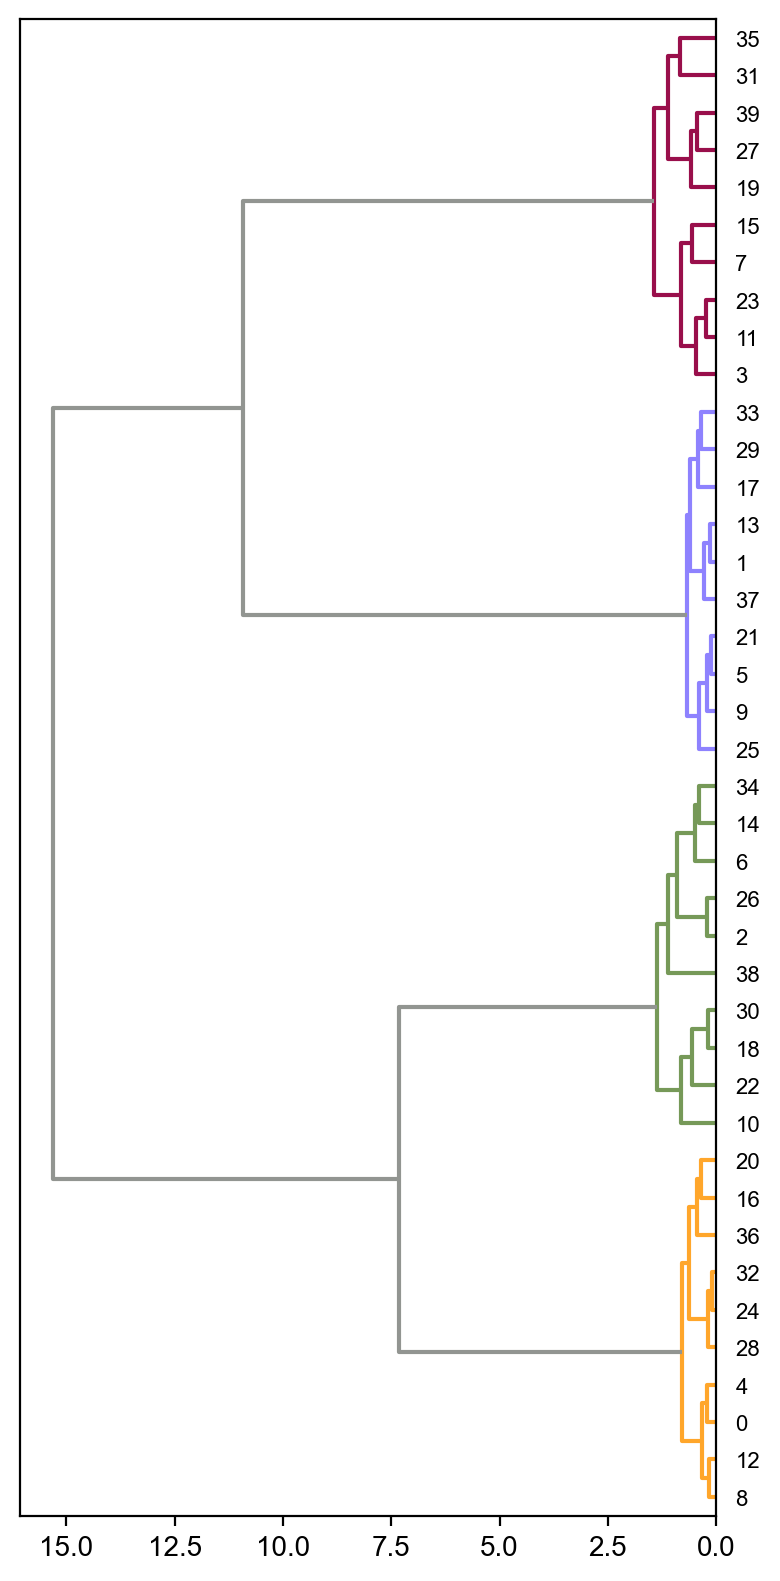

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,8))

# set the color palette
clusterColors = ['xkcd:mango','xkcd:moss', 'xkcd:periwinkle', "xkcd:berry"]
set_link_color_palette(clusterColors)

dendrogram(Z=linkageMatrix, orientation="left", ax=ax, color_threshold=5, above_threshold_color="xkcd:grey")

plt.tight_layout()

I'll replot our z-scored profiles from above, but now colored by cluster.

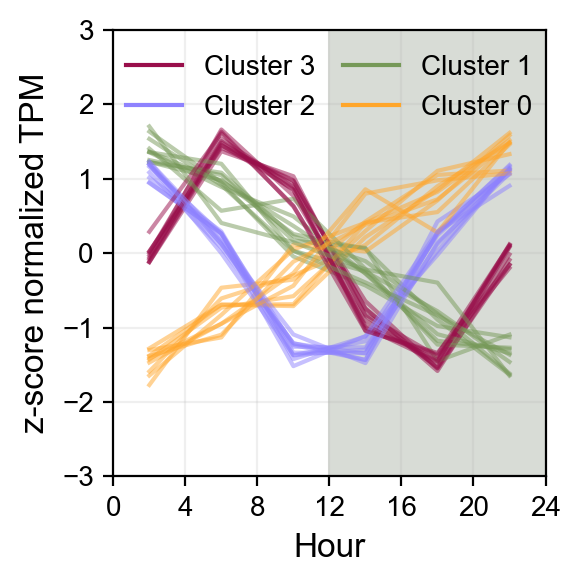

In [52]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3,3))

legendClusters = []
for i, ind in enumerate(expScaled.index):
    cluster = expSorted.loc[ind]["Cluster"].astype(int)
    if cluster in legendClusters:
        ax.plot(expScaled.columns, expScaled.loc[ind], color=clusterColors[cluster], alpha=0.5)  
    else: # little hack to only add a legend object once per cluster
        ax.plot(expScaled.columns, expScaled.loc[ind], color=clusterColors[cluster], alpha=0.5, label="Cluster {}".format(cluster)) 
        legendClusters.append(cluster)

ax.set_xticks(np.arange(0,28,4))
ax.set_xlim(0,24)
ax.set_ylim(-3,3)  

nightPatch = mpatches.Rectangle(xy=(12,ax.get_ylim()[0]), width=12, height=ax.get_ylim()[1]-ax.get_ylim()[0], color="xkcd:light gray") 
ax.add_patch(nightPatch)  

ax.grid(alpha=0.2)

legend = ax.legend(loc="upper center", ncols=2, frameon=False, fontsize=10, columnspacing=1)
# Set the marker lines in the legend to opaque
# even though the original labels were slightly transparent
for legend_handle in legend.legend_handles:
    legend_handle.set_alpha(1)

ax.set_ylabel("z-score normalized TPM", size=12)
ax.set_xlabel("Hour", size=12)

plt.tight_layout()

Now let's put everything together, and I'll even throw in a map for fun. The map data come from  [Natural Earth](https://www.naturalearthdata.com/downloads/).

In [53]:
import geopandas as gpd
states = gpd.read_file("../Data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
lakes = gpd.read_file("../Data/ne_10m_lakes/ne_10m_lakes.shp")
borderLakes = lakes[lakes["name"].isin(["Lake Michigan", "Lake Huron", "Lake Superior"])]

/var/folders/6y/1tfk97jj5pz9h97s08kn33zm0000gn/T/ipykernel_23458/2377116648.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


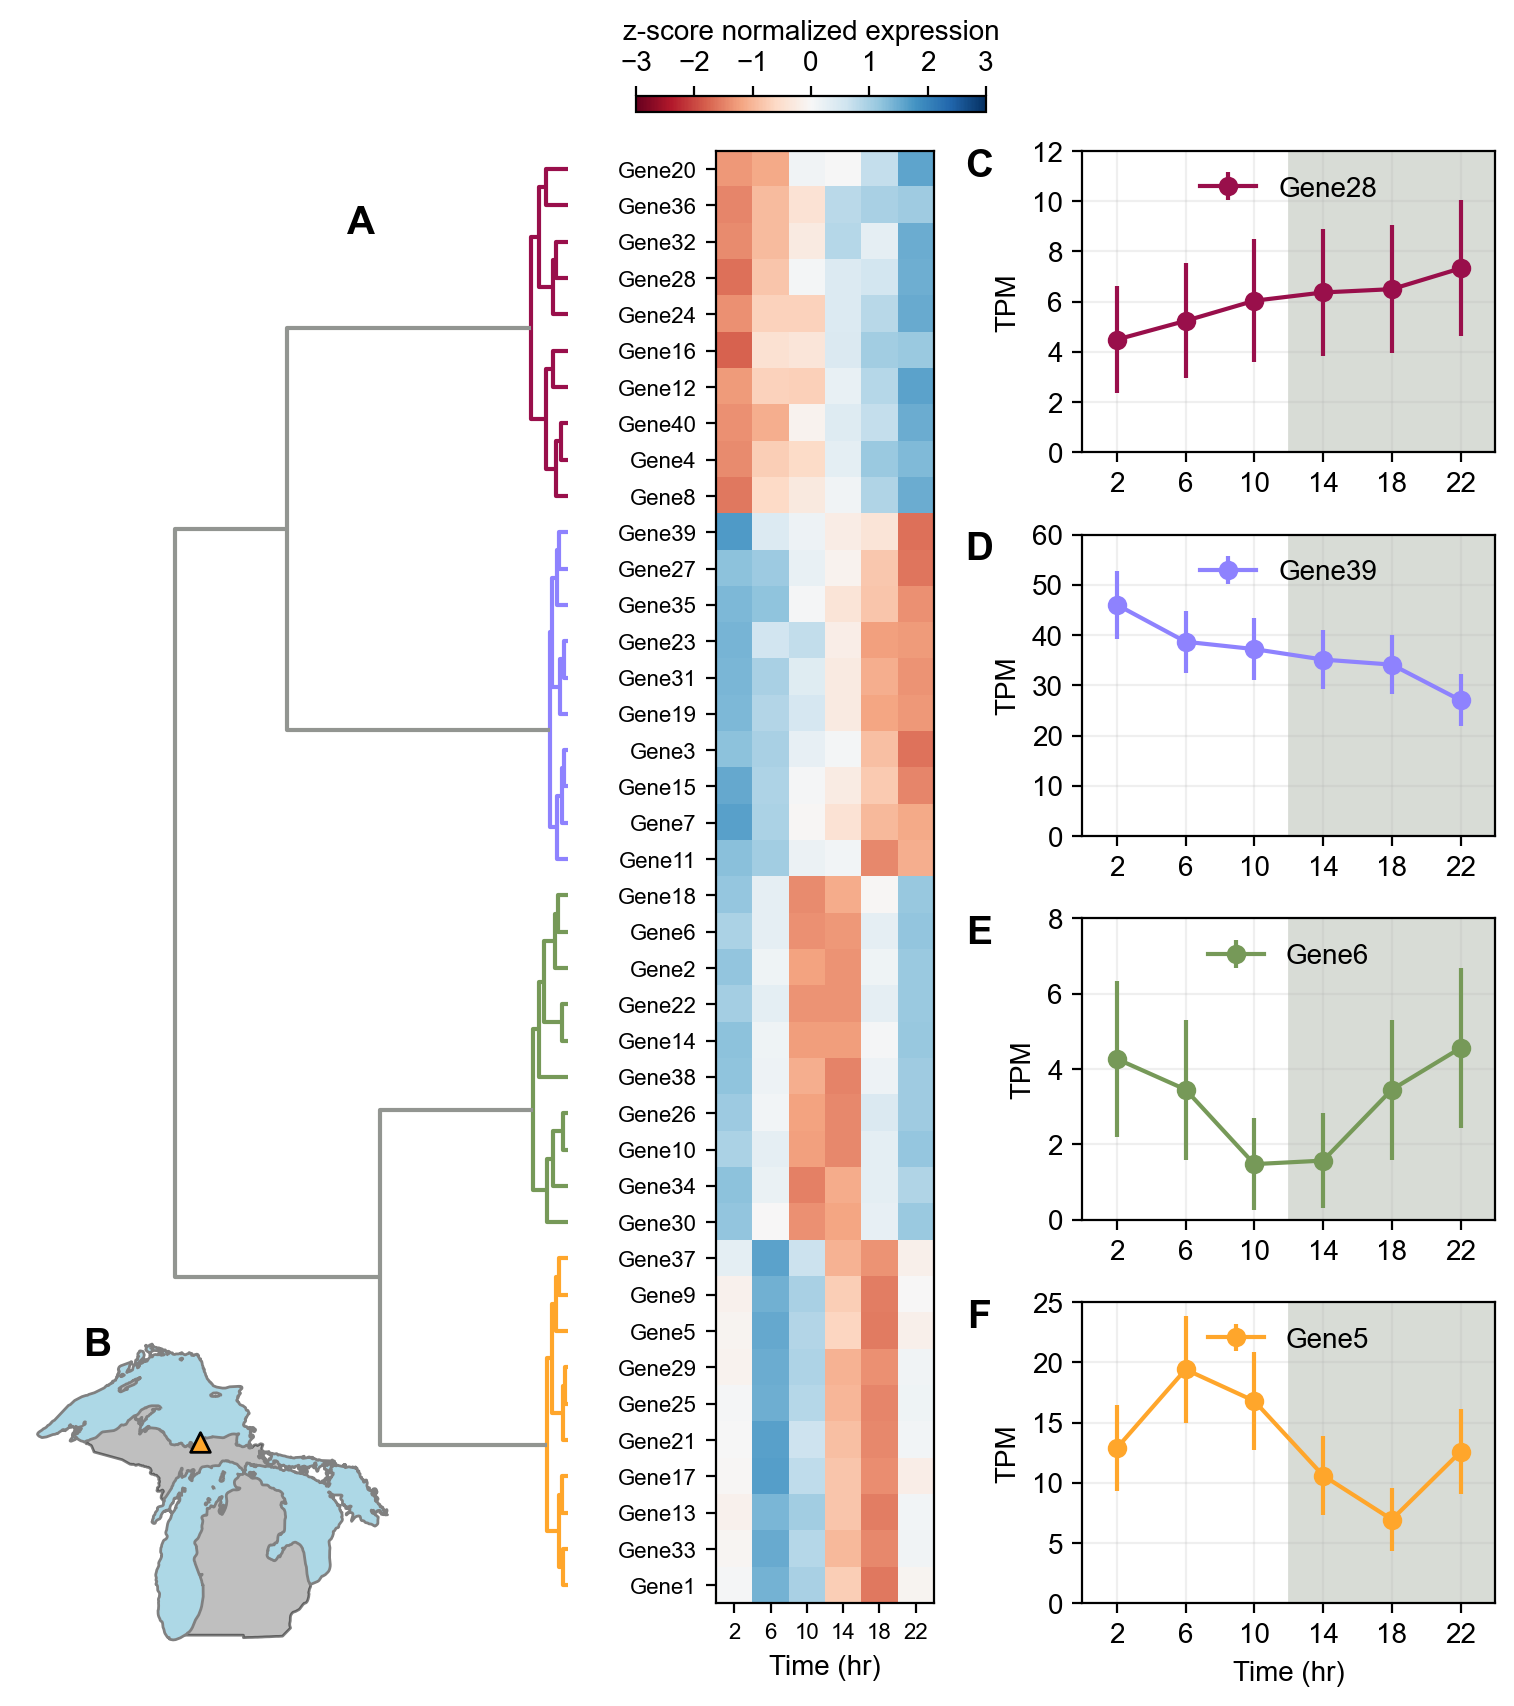

In [54]:
fig, ax = plt.subplot_mosaic("""AAHHCC
                                AAHHDD
                                AAHHEE
                                AAHHFF""", figsize=(7,8))

# Draw the dendrogram
dendrogram(Z=linkageMatrix, orientation="left", ax=ax['A'], color_threshold=5, above_threshold_color="xkcd:grey")
ax['A'].axis('off') # turn off the axis

# Add the heatmap
hmap = ax['H'].imshow(expSorted, cmap=cmapDict["diverging"], vmin=-3, vmax=3)
ax['H'].set_xticks(np.arange(0,6,1))
ax['H'].set_xticklabels(np.arange(2,26,4), size=8)
ax['H'].set_xlim(-0.5,5.5)
ax['H'].set_yticks(range(len(expSorted)))
ax['H'].set_yticklabels(list(expSorted.index), size=8)
ax['H'].set_xlabel("Time (hr)")

# Create a new axes for the heatmap's colorbar
cbar_ax = fig.add_axes([0.365, 1.0, 0.25, 0.01])  # [left, bottom, width, height] of entire figure
# Add heatmap and style
cbar = fig.colorbar(hmap, cax=cbar_ax, aspect=20, fraction=0.1, orientation="horizontal", location='top')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("z-score normalized expression",size=10)

# Plot example genes down right column
exampleGenes = ['Gene28','Gene39', 'Gene6','Gene5']
for g,l,c in zip(exampleGenes,'CDEF',clusterColors[::-1]):
    ax[l].errorbar(x=exp.columns, y=exp.loc[g], yerr=np.sqrt(np.abs(exp.loc[g])), marker="o", color=c, label=g)
    ax[l].legend(frameon=False, loc="upper center")
    nightPatch = mpatches.Rectangle(xy=(12,0), width=12, height=ax[l].get_ylim()[1]*1.5, color="xkcd:light gray") 
    ax[l].add_patch(nightPatch)  
    ax[l].set_xticks(np.arange(2,26,4))
    ax[l].set_xlim(0,24)
    ax[l].grid(alpha=0.2)
    ax[l].set_ylabel("TPM")

# Create a new axes for the map
map_ax = fig.add_axes([-0.075, 0.0, 0.275, 0.275])
states[states["name"]=="Michigan"].plot(ax=map_ax, color='grey', edgecolor='black', alpha=0.5)
borderLakes.plot(ax=map_ax, color='lightblue', edgecolor='grey')
map_ax.scatter([-86.3186],[46.5688], marker="^", color="xkcd:mango", edgecolor="black", s=50)
map_ax.axis('off')

# Format ticks and lims
ax['C'].set_yticks(np.arange(0,14,2))
ax['C'].set_ylim(0,12)
ax['D'].set_yticks(np.arange(0,70,10))
ax['D'].set_ylim(0,60)
ax['E'].set_yticks(np.arange(0,10,2))
ax['E'].set_ylim(0,8)
ax['F'].set_yticks(np.arange(0,30,5))
ax['F'].set_ylim(0,25)
ax['F'].set_xlabel("Time (hr)")

# Add subplot letters
ax['A'].text(0.5,  0.95, 'A', transform=ax['A'].transAxes, weight="bold", fontsize=14, ha='center', va='center')
map_ax.text(0.2, 0.95, 'B', transform=map_ax.transAxes, weight="bold", fontsize=14, ha='center', va='center')
ax['C'].text(-0.25, 0.95, 'C', transform=ax['C'].transAxes, weight="bold", fontsize=14, ha='center', va='center')
ax['D'].text(-0.25, 0.95, 'D', transform=ax['D'].transAxes, weight="bold", fontsize=14, ha='center', va='center')
ax['E'].text(-0.25, 0.95, 'E', transform=ax['E'].transAxes, weight="bold", fontsize=14, ha='center', va='center')
ax['F'].text(-0.25, 0.95, 'F', transform=ax['F'].transAxes, weight="bold", fontsize=14, ha='center', va='center')

plt.tight_layout()

In this final plot we're put together just about all our skills.
- We've got a complex layout with nicely labeled subplots
- Our heatmap has an appropriately chosen colormap and has been reordered to highlight groups of potentially interacting genes
- Examplars of each cluster are plotted with some form of central value and variation (let's say mean and standard error)
    - These subplots have sensible axes, legends, and ticks that are labeled
 
While the code block to make this figure is 64 lines, even complex figures can come together quickly after you've taken the time to make nice individual plots. So as you explore your data and run tests, take a _little_ extra time to make a decent plot of each interesting finding (your advisor will appreciate this) so that you can more-or-less copy and paste them into your final figures. Writing decent code the first time allows you to recycle it indefinitely.